In [30]:
import numpy as np
import h5py
import pandas as pd
from numpy import linalg as LA
from astropy.io import fits
from astropy.table import Table
import matplotlib.pyplot as plt
from matplotlib import cm
import pickle

In [2]:
from sconce.utils import cart2sph, sph2cart
from sconce.EucSCMS import KDE
from sconce.DirSCMS import DirKDE
from sconce.EucSCMS_RayFunc import KDE_Ray, MS_Ray, SCMSLog_Ray
from sconce.DirSCMS_RayFunc import DirMS_Ray, DirSCMSLog_Ray
from sconce.DirLinSCMS_RayFunc import DirLinKDE_Ray, DirLinMS_Ray, DirLinSCMSLog_Ray

import ray

## Illustris Data at $z=0$

Illustris-3 data: https://www.illustris-project.org/data/downloads/Illustris-3/ (z=0).

The description of columns can be found at https://arxiv.org/abs/1504.00362.

Note that the scale factor $a=1/(1+z)$.

In [3]:
f0 = h5py.File('Data_Outputs/Illustris_Data/groups_135.0.hdf5')
f1 = h5py.File('Data_Outputs/Illustris_Data/groups_135.1.hdf5')
print(list(f0.keys()))
list(f1.keys())

['Group', 'Header', 'Offsets', 'Subhalo']


['Group', 'Header', 'Offsets', 'Subhalo']

In [4]:
FOF_halo0 = pd.DataFrame({list(f0['Group'].keys())[0]: np.array(f0['Group/'+list(f0['Group'].keys())[0]])})
for k in f0['Group'].keys():
    FOF_halo0[k] = list(f0['Group/'+k])
    
FOF_halo1 = pd.DataFrame({list(f1['Group'].keys())[0]: np.array(f1['Group/'+list(f1['Group'].keys())[0]])})
for k in f1['Group'].keys():
    FOF_halo1[k] = list(f1['Group/'+k])

FOF_halo = pd.concat([FOF_halo0, FOF_halo1], axis=0).reset_index()

We convert the 3D coordinates of the above Illustris halo data in the periodic box to their (RA,DEC,$z$) coordinates by assuming an observer placed at (0, 0, 0).

In [5]:
from halotools.mock_observables import ra_dec_z
from astropy.cosmology import WMAP9

dat = pd.DataFrame(np.concatenate([np.concatenate(FOF_halo['GroupPos'], axis=0).reshape(-1,3)/(10**3), 
                                   np.concatenate(FOF_halo['GroupVel'], axis=0).reshape(-1,3)], axis=1))
dat.columns = ['X', 'Y', 'Z', 'v_x', 'v_y', 'v_z']

RA_h, DEC_h, z_obs = ra_dec_z(dat[['X', 'Y', 'Z']].values, dat[['v_x', 'v_y', 'v_z']].values, cosmo = WMAP9)
RA_h, DEC_h, z_real = ra_dec_z(dat[['X', 'Y', 'Z']].values, np.zeros_like(dat[['v_x', 'v_y', 'v_z']].values), 
                              cosmo = WMAP9)
RA_h = 180*RA_h/np.pi
DEC_h = -180*DEC_h/np.pi

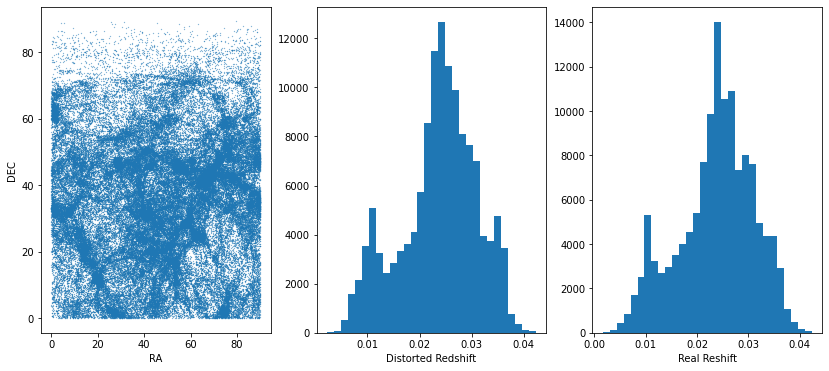

In [6]:
plt.figure(figsize=(14, 6))
plt.subplot(131)
plt.scatter(RA_h, DEC_h, s=0.05)
plt.xlabel('RA')
plt.ylabel('DEC')

plt.subplot(132)
plt.hist(z_obs, bins=30)
plt.xlabel('Distorted Redshift')

plt.subplot(133)
plt.hist(z_real, bins=30)
plt.xlabel('Real Reshift')
plt.show()

In [7]:
mock_dat_z0 = pd.concat([FOF_halo[['GroupBHMass', 'GroupBHMdot', 'GroupFirstSub',
                                   'GroupGasMetallicity', 'GroupMass']], 
                         dat[['X', 'Y', 'Z', 'v_x', 'v_y', 'v_z']]], axis=1)
mock_dat_z0['RA'] = RA_h
mock_dat_z0['DEC'] = DEC_h
mock_dat_z0['z_obs'] = z_obs
mock_dat_z0['z_true'] = z_real

mock_dat_z0.to_csv('Data_Outputs/Illustris_Data/Illustris_z0_new.csv', index=False)

In [8]:
mock_dat_z0

GroupBHMass  GroupBHMdot  GroupFirstSub  GroupGasMetallicity  \
0          1.361113     0.083696              0         3.695629e-03   
1          1.159228     0.038631            608         3.464960e-03   
2          1.020205     0.199749           1030         3.311476e-03   
3          1.035143     0.018102           1396         3.789605e-03   
4          0.576488     0.017309           1801         3.313053e-03   
...             ...          ...            ...                  ...   
131722     0.000000     0.000000             -1         2.968206e-04   
131723     0.000000     0.000000             -1         5.139151e-04   
131724     0.000000     0.000000         121206         2.371711e-09   
131725     0.000000     0.000000         121207         5.357914e-07   
131726     0.000000     0.000000         121208         8.492125e-08   

           GroupMass          X          Y          Z         v_x         v_y  \
0       33708.917969   0.900425  26.286690  18.321949   39.760448 -149.972763   
1       28027.013672  19.766018  47.516933  49.014603 -153.339844   75.936981   
2       23216.947266  10.908239  50.865517  47.651791  266.508148  -94.131004   
3       20976.435547  68.562469  58.939396  53.864418  311.296539  -53.277534   
4       16711.937500  74.665428  18.299120  23.950159   97.329285  217.102417   
...              ...        ...        ...        ...         ...         ...   
131722      0.219432  67.119324  23.753326  14.342937  253.114334   -2.810158   
131723      0.230051  67.110687  32.666523  74.486603  101.020607  -33.791771   
131724      0.750384  64.348183  31.243700  39.493546   97.247871  -36.105125   
131725      0.752275  64.714821  72.960335  53.685600   88.157677 -241.693161   
131726      0.748808  61.629517  66.571640  32.454777  -42.727631  162.087204   

               v_z         RA        DEC     z_obs    z_true  
0        27.541697  88.038155  34.860924  0.010359  0.010717  
1         4.810725  67.413742  43.603500  0.023868  0.023829  
2        83.669357  77.896095  42.489464  0.023755  0.023653  
3       -81.070648  40.683842  30.784542  0.035830  0.035376  
4        75.181580  13.770709  17.304235  0.027571  0.027016  
...            ...        ...        ...       ...       ...  
131722  323.324860  19.488718  11.389797  0.025369  0.024355  
131723  307.139404  25.954777  44.941532  0.036381  0.035446  
131724 -115.658760  25.898489  28.903467  0.027442  0.027418  
131725 -183.906830  48.427410  28.831804  0.036760  0.037438  
131726   95.306702  47.207642  19.684652  0.032768  0.032366  

[131727 rows x 15 columns]

### Filament Detection in the observed redshift space (standard 3D SCMS Method)

In [9]:
X_halo = mock_dat_z0['z_obs'] * np.cos(mock_dat_z0['RA']/180*np.pi) * np.cos(mock_dat_z0['DEC']/180*np.pi)
Y_halo = mock_dat_z0['z_obs'] * np.sin(mock_dat_z0['RA']/180*np.pi) * np.cos(mock_dat_z0['DEC']/180*np.pi)
Z_halo = mock_dat_z0['z_obs'] * np.sin(mock_dat_z0['DEC']/180*np.pi)

Eu_dat = np.concatenate([X_halo.values.reshape(-1,1), Y_halo.values.reshape(-1,1), 
                         Z_halo.values.reshape(-1,1)], axis=1)

In [ ]:
for fac in [0.4, 0.8, 1.2, 1.5, 1.8, 2]:
    data = Eu_dat
    d = data.shape[1]
    n = data.shape[0]
    fac = 1.5
    bw_Eu = fac*(1/(d+2))**(1/(d+4))*(n**(-1/(d+4)))*np.min(np.std(data, axis=0))
    print("The current bandwidth for Euclidean SCMS is "+ str(bw_Eu) + ".\n")
    
    # Removing some noisy observations
    # d_Eu_dat = KDE(Eu_dat, Eu_dat, h=bw_Eu)
    ray.init()
    mesh_0 = Eu_dat
    dataset = Eu_dat
    chunksize = 20
    num_p = mesh_0.shape[0]
    result_ids = []
    for i in range(0, num_p, chunksize):
        result_ids.append(KDE_Ray.remote(mesh_0[i:(i+chunksize)], dataset, h=bw_Eu))
    d_Eu_dat = ray.get(result_ids)
    d_Eu_dat = np.concatenate(d_Eu_dat, axis=0)
    ray.shutdown()
    
    tau = np.std(d_Eu_dat)
    Eu_dat_thres = Eu_dat[d_Eu_dat >= tau,:]
    if Eu_dat_thres.shape[0]/Eu_dat.shape[0] < 0.8:
        Eu_dat_thres = Eu_dat[d_Eu_dat >= np.quantile(d_Eu_dat, 0.2)]
    print("Euclidean Thresholding Ratio: "+str(Eu_dat_thres.shape[0]/Eu_dat.shape[0]))
    
    nrows, ncols = (90, 90)
    lon_m, lat_m, Z_m = np.meshgrid(np.linspace(0, 90, ncols), np.linspace(0, 90, nrows), 
                                    np.linspace(min(mock_dat_z0['z_obs']), max(mock_dat_z0['z_obs']), 15))
    xg = Z_m * np.cos(lon_m/180 * np.pi) * np.cos(lat_m/180 * np.pi)
    yg = Z_m * np.sin(lon_m/180 * np.pi) * np.cos(lat_m/180 * np.pi)
    zg = Z_m * np.sin(lat_m/180 * np.pi)
    mesh_Eu = np.concatenate([xg.reshape(-1,1), yg.reshape(-1,1), zg.reshape(-1,1)], axis=1)
    
    ray.init()
    mesh_0 = mesh_Eu
    dataset = Eu_dat_thres
    chunksize = 20
    num_p = mesh_0.shape[0]
    result_ids = []
    for i in range(0, num_p, chunksize):
        result_ids.append(KDE_Ray.remote(mesh_0[i:(i+chunksize)], dataset, h=bw_Eu))
    d_m_Eu = ray.get(result_ids)
    d_m_Eu = np.concatenate(d_m_Eu, axis=0)
    ray.shutdown()
    
    # Thresholding
    mesh_Eu_thres = mesh_Eu[d_m_Eu >= np.quantile(d_m_Eu, 0.15)]
    print("Remaining mesh point ratio: "+str(mesh_Eu_thres.shape[0]/mesh_Eu.shape[0]))
    
    # MS
    start = time.time()
    ray.init()
    mesh_0 = mesh_Eu_thres
    dataset = Eu_dat_thres
    chunksize = 10
    num_p = mesh_0.shape[0]
    result_ids = []
    for i in range(0, num_p, chunksize):
        result_ids.append(MS_Ray.remote(mesh_0[i:(i+chunksize)], dataset, h=bw_Eu, 
                                        eps=1e-7, max_iter=5000))
    EuMS_pts = ray.get(result_ids)
    EuMS_pts = np.concatenate(EuMS_pts, axis=0)
    ray.shutdown()
    print("Elasped time: "+ str(time.time()-start)+'s.\n')   
    
    with open("./Data_Outputs/Illustris_Data/Illustris_EuMS_z0_"+str(fac)+"h.dat", "wb") as file:
        pickle.dump([bw_Eu, EuMS_pts], file)
        
    # SCMS
    start = time.time()
    ray.init()
    mesh_0 = mesh_Eu_thres
    dataset = Eu_dat_thres
    chunksize = 10
    num_p = mesh_0.shape[0]
    result_ids = []
    for i in range(0, num_p, chunksize):
        result_ids.append(SCMSLog_Ray.remote(mesh_0[i:(i+chunksize)], dataset, d=1, h=bw_Eu, 
                                             eps=1e-7, max_iter=5000))
    EuSCMS_pts = ray.get(result_ids)
    EuSCMS_pts = np.concatenate(EuSCMS_pts, axis=0)
    ray.shutdown()
    
    print("Elasped time: "+ str(time.time()-start)+'s.\n')   
    with open("./Data_Outputs/Illustris_Data/Illustris_EuSCMS_z0_"+str(fac)+"h.dat", "wb") as file:
        pickle.dump([bw_Eu, EuSCMS_pts], file)

### Filament Detection in the true/cosmological redshift space (standard 3D SCMS method)

In [10]:
X_halo = mock_dat_z0['z_obs'] * np.cos(mock_dat_z0['RA']/180*np.pi) * np.cos(mock_dat_z0['DEC']/180*np.pi)
Y_halo = mock_dat_z0['z_obs'] * np.sin(mock_dat_z0['RA']/180*np.pi) * np.cos(mock_dat_z0['DEC']/180*np.pi)
Z_halo = mock_dat_z0['z_obs'] * np.sin(mock_dat_z0['DEC']/180*np.pi)

Eu_dat_obs = np.concatenate([X_halo.values.reshape(-1,1), Y_halo.values.reshape(-1,1), 
                         Z_halo.values.reshape(-1,1)], axis=1)

X_halo = mock_dat_z0['z_true'] * np.cos(mock_dat_z0['RA']/180*np.pi) * np.cos(mock_dat_z0['DEC']/180*np.pi)
Y_halo = mock_dat_z0['z_true'] * np.sin(mock_dat_z0['RA']/180*np.pi) * np.cos(mock_dat_z0['DEC']/180*np.pi)
Z_halo = mock_dat_z0['z_true'] * np.sin(mock_dat_z0['DEC']/180*np.pi)

Eu_dat = np.concatenate([X_halo.values.reshape(-1,1), Y_halo.values.reshape(-1,1), 
                         Z_halo.values.reshape(-1,1)], axis=1)

In [ ]:
### Warnings: this chunk of code takes several days to execute!! One can choose to 
### load our pre-computed results instead.

for fac in [0.4, 0.8, 1.2, 1.5, 1.8, 2]:
    # Ensure that the bandwidth parameters are the same as the observed redshift scenarios.
    data = Eu_dat_obs
    d = data.shape[1]
    n = data.shape[0]
    fac = 1.5
    bw_Eu = fac*(1/(d+2))**(1/(d+4))*(n**(-1/(d+4)))*np.min(np.std(data, axis=0))
    print("The current bandwidth for Euclidean SCMS is "+ str(bw_Eu) + ".\n")
    
    # Removing some noisy observations
    # d_Eu_dat = KDE(Eu_dat, Eu_dat, h=bw_Eu)
    ray.init()
    mesh_0 = Eu_dat
    dataset = Eu_dat
    chunksize = 20
    num_p = mesh_0.shape[0]
    result_ids = []
    for i in range(0, num_p, chunksize):
        result_ids.append(KDE_Ray.remote(mesh_0[i:(i+chunksize)], dataset, h=bw_Eu))
    d_Eu_dat = ray.get(result_ids)
    d_Eu_dat = np.concatenate(d_Eu_dat, axis=0)
    ray.shutdown()
    
    tau = np.std(d_Eu_dat)
    Eu_dat_thres = Eu_dat[d_Eu_dat >= tau,:]
    if Eu_dat_thres.shape[0]/Eu_dat.shape[0] < 0.8:
        Eu_dat_thres = Eu_dat[d_Eu_dat >= np.quantile(d_Eu_dat, 0.2)]
    print("Euclidean Thresholding Ratio: "+str(Eu_dat_thres.shape[0]/Eu_dat.shape[0]))
    
    nrows, ncols = (90, 90)
    lon_m, lat_m, Z_m = np.meshgrid(np.linspace(0, 90, ncols), np.linspace(0, 90, nrows), 
                                    np.linspace(min(mock_dat_z0['z_true']), max(mock_dat_z0['z_true']), 15))
    xg = Z_m * np.cos(lon_m/180 * np.pi) * np.cos(lat_m/180 * np.pi)
    yg = Z_m * np.sin(lon_m/180 * np.pi) * np.cos(lat_m/180 * np.pi)
    zg = Z_m * np.sin(lat_m/180 * np.pi)
    mesh_Eu = np.concatenate([xg.reshape(-1,1), yg.reshape(-1,1), zg.reshape(-1,1)], axis=1)
    
    ray.init()
    mesh_0 = mesh_Eu
    dataset = Eu_dat_thres
    chunksize = 20
    num_p = mesh_0.shape[0]
    result_ids = []
    for i in range(0, num_p, chunksize):
        result_ids.append(KDE_Ray.remote(mesh_0[i:(i+chunksize)], dataset, h=bw_Eu))
    d_m_Eu = ray.get(result_ids)
    d_m_Eu = np.concatenate(d_m_Eu, axis=0)
    ray.shutdown()
    
    # Thresholding
    mesh_Eu_thres = mesh_Eu[d_m_Eu >= np.quantile(d_m_Eu, 0.15)]
    print("Remaining mesh point ratio: "+str(mesh_Eu_thres.shape[0]/mesh_Eu.shape[0]))
    
    # MS
    start = time.time()
    ray.init()
    mesh_0 = mesh_Eu_thres
    dataset = Eu_dat_thres
    chunksize = 10
    num_p = mesh_0.shape[0]
    result_ids = []
    for i in range(0, num_p, chunksize):
        result_ids.append(MS_Ray.remote(mesh_0[i:(i+chunksize)], dataset, h=bw_Eu, 
                                        eps=1e-7, max_iter=5000))
    EuMS_pts = ray.get(result_ids)
    EuMS_pts = np.concatenate(EuMS_pts, axis=0)
    ray.shutdown()
    print("Elasped time: "+ str(time.time()-start)+'s.\n')   
    
    with open("./Data_Outputs/Illustris_Data/Illustris_EuMS_z0_"+str(fac)+"h_true.dat", "wb") as file:
        pickle.dump([bw_Eu, EuMS_pts], file)
        
    # SCMS
    start = time.time()
    ray.init()
    mesh_0 = mesh_Eu_thres
    dataset = Eu_dat_thres
    chunksize = 10
    num_p = mesh_0.shape[0]
    result_ids = []
    for i in range(0, num_p, chunksize):
        result_ids.append(SCMSLog_Ray.remote(mesh_0[i:(i+chunksize)], dataset, d=1, h=bw_Eu, 
                                             eps=1e-7, max_iter=5000))
    EuSCMS_pts = ray.get(result_ids)
    EuSCMS_pts = np.concatenate(EuSCMS_pts, axis=0)
    ray.shutdown()
    
    print("Elasped time: "+ str(time.time()-start)+'s.\n')   
    with open("./Data_Outputs/Illustris_Data/Illustris_EuSCMS_z0_"+str(fac)+"h_true.dat", "wb") as file:
        pickle.dump([bw_Eu, EuSCMS_pts], file)

In [11]:
## Loading the standard SCMS filaments in the observed redshift space
with open("./Data_Outputs/Illustris_Data/Illustris_EuSCMS_z0_1.5h.dat", "rb") as file:
    bw_Eu, EuFila_obs = pickle.load(file)

print(EuFila_obs.shape)

X_f_obs = WMAP9.h * WMAP9.comoving_distance(EuFila_obs[:,0]).value
Y_f_obs = WMAP9.h * WMAP9.comoving_distance(EuFila_obs[:,1]).value
Z_f_obs = WMAP9.h * WMAP9.comoving_distance(EuFila_obs[:,2]).value

EuFila_obs_comov = np.vstack((X_f_obs, Y_f_obs, Z_f_obs)).T

## Loading the standard SCMS filaments in the true/cosmological redshift space
with open("./Data_Outputs/Illustris_Data/Illustris_EuSCMS_z0_1.5h_true.dat", "rb") as file:
    bw_Eu, EuFila_cos = pickle.load(file)

print(EuFila_cos.shape)

X_f_cos = WMAP9.h * WMAP9.comoving_distance(EuFila_cos[:,0]).value
Y_f_cos = WMAP9.h * WMAP9.comoving_distance(EuFila_cos[:,1]).value
Z_f_cos = WMAP9.h * WMAP9.comoving_distance(EuFila_cos[:,2]).value

EuFila_cos_comov = np.vstack((X_f_cos, Y_f_cos, Z_f_cos)).T

(103275, 3)
(103274, 3)


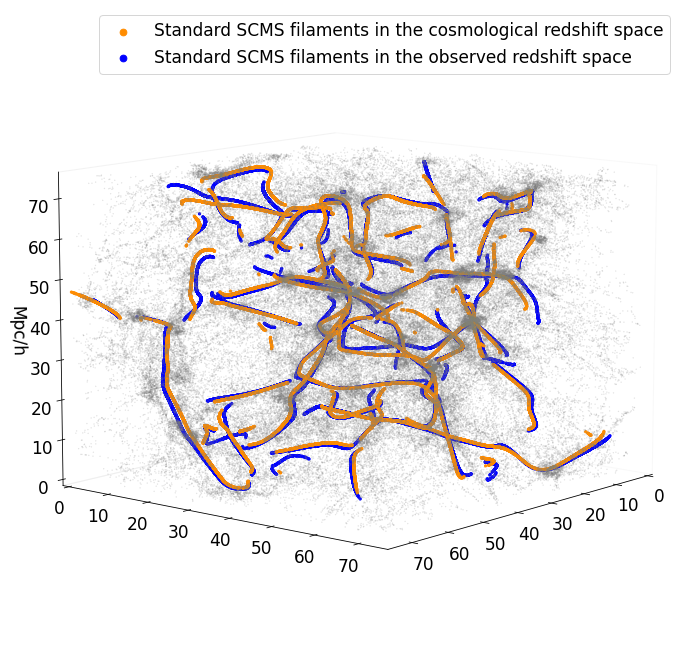

In [12]:
X_halo = WMAP9.h * WMAP9.comoving_distance(mock_dat_z0['z_true']).value * np.cos(mock_dat_z0['RA']/180*np.pi) * np.cos(mock_dat_z0['DEC']/180*np.pi)
Y_halo = WMAP9.h * WMAP9.comoving_distance(mock_dat_z0['z_true']).value * np.sin(mock_dat_z0['RA']/180*np.pi) * np.cos(mock_dat_z0['DEC']/180*np.pi)
Z_halo = WMAP9.h * WMAP9.comoving_distance(mock_dat_z0['z_true']).value * np.sin(mock_dat_z0['DEC']/180*np.pi)

plt.rcParams.update({'font.size': 17})  # Change the font sizes of ouput figures
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.view_init(10, 40)
ax.scatter3D(X_halo, Y_halo, Z_halo, color='grey', alpha=0.3, s=0.1)
ax.scatter3D(EuFila_cos_comov[:,0], EuFila_cos_comov[:,1], EuFila_cos_comov[:,2], color='darkorange', 
             alpha=1, s=5, label='Standard SCMS filaments in the cosmological redshift space')
ax.scatter3D(EuFila_obs_comov[:,0], EuFila_obs_comov[:,1], EuFila_obs_comov[:,2], color='blue', 
             alpha=1, s=5, label='Standard SCMS filaments in the observed redshift space')
# ax.set_xlabel('Mpc/h')
# ax.set_ylabel('Mpc/h')
ax.set_zlabel('Mpc/h')
plt.legend(markerscale=3)
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

ax.grid(False)
ax.set_xlim(0, 75)
ax.set_ylim(0, 75)
ax.set_zlim(0, 75)
fig.tight_layout()
fig.savefig('./Figures/Eu_SCMS_illustris.jpg', bbox_inches="tight", dpi=150)
# plt.show()

#### Distances between the Standard SCMS filament in the observed redshift space and the one in the true/cosmological redshift space

In [13]:
def DistToFila(x, tar_fila):
    x = x.values
    return min(LA.norm(tar_fila - x, axis=1))

@ray.remote
def DistToFila_Fs(pts, tar_fila):
    dist = np.zeros((pts.shape[0], ))
    for i in range(pts.shape[0]):
        dist[i] = min(LA.norm(tar_fila - pts[i,:], axis=1))
    return dist

In [ ]:
for fac in [0.4, 0.8, 1.2, 1.5, 1.8, 2]:
    ## Loading the Standard filaments in the observed redshift space
    with open("./Data_Outputs/Illustris_Data/Illustris_EuSCMS_z0_"+str(fac)+"h.dat", "rb") as file:
        bw_Eu, EuFila_obs = pickle.load(file)
    
    X_f_obs = WMAP9.h * WMAP9.comoving_distance(EuFila_obs[:,0]).value
    Y_f_obs = WMAP9.h * WMAP9.comoving_distance(EuFila_obs[:,1]).value
    Z_f_obs = WMAP9.h * WMAP9.comoving_distance(EuFila_obs[:,2]).value
    
    EuFila_obs_comov = np.vstack((X_f_obs, Y_f_obs, Z_f_obs)).T
    
    ## Loading the Eu filaments in the true redshift space
    with open("./Data_Outputs/Illustris_Data/Illustris_EuSCMS_z0_"+str(fac)+"h_true.dat", "rb") as file:
        bw_Eu, EuFila_cos = pickle.load(file)
        
    X_f_cos = WMAP9.h * WMAP9.comoving_distance(EuFila_cos[:,0]).value
    Y_f_cos = WMAP9.h * WMAP9.comoving_distance(EuFila_cos[:,1]).value
    Z_f_cos = WMAP9.h * WMAP9.comoving_distance(EuFila_cos[:,2]).value
    
    EuFila_cos_comov = np.vstack((X_f_cos, Y_f_cos, Z_f_cos)).T
    
    ray.init()
    chunksize = 20
    data = EuFila_obs_comov
    num_p = data.shape[0]
    result_ids = []
    for i in range(0, num_p, chunksize):
        result_ids.append(DistToFila_Fs.remote(data[i:(i+chunksize)], tar_fila=EuFila_cos_comov))
    Eu_obs_to_cos_comov = ray.get(result_ids)
    Eu_obs_to_cos_comov = np.concatenate(Eu_obs_to_cos_comov, axis=0)
    ray.shutdown()
    
    ray.init()
    chunksize = 20
    data = EuFila_cos_comov
    num_p = data.shape[0]
    result_ids = []
    for i in range(0, num_p, chunksize):
        result_ids.append(DistToFila_Fs.remote(data[i:(i+chunksize)], tar_fila=EuFila_obs_comov))
    Eu_cos_to_obs_comov = ray.get(result_ids)
    Eu_cos_to_obs_comov = np.concatenate(Eu_cos_to_obs_comov, axis=0)
    ray.shutdown()
        
    with open("./Data_Outputs/Illustris_Data/dist_diff_EuSCMS_obs_cos_z0_"+str(fac)+"h_comov.dat", "wb") as file:
        pickle.dump([Eu_obs_to_cos_comov, Eu_cos_to_obs_comov], file)

#### Halo Number Density (Standard 3D SCMS method)

In [14]:
## FOF halos in the observed redshift space
X_halo = WMAP9.h * WMAP9.comoving_distance(mock_dat_z0['z_obs']).value * np.cos(mock_dat_z0['RA']/180*np.pi) * np.cos(mock_dat_z0['DEC']/180*np.pi)
Y_halo = WMAP9.h * WMAP9.comoving_distance(mock_dat_z0['z_obs']).value * np.sin(mock_dat_z0['RA']/180*np.pi) * np.cos(mock_dat_z0['DEC']/180*np.pi)
Z_halo = WMAP9.h * WMAP9.comoving_distance(mock_dat_z0['z_obs']).value * np.sin(mock_dat_z0['DEC']/180*np.pi)

# The unit is Mpc/h
halo_pos = np.vstack((X_halo, Y_halo, Z_halo)).T

In [15]:
def GalaxyNumDenst(pt, gal_dat):
    pt = pt.values
    return sum(LA.norm(gal_dat - pt, axis=1) <= 0.001)

@ray.remote
def GalaxyNumDenst_Fs(fila_pt, gal_dat, thres_val=0.001):
    gal_nd = np.zeros((fila_pt.shape[0], ))
    for i in range(fila_pt.shape[0]):
        gal_nd[i] = sum(LA.norm(gal_dat -fila_pt[i,:], axis=1) <= thres_val)
    return gal_nd

In [ ]:
for fac in [0.4, 0.8, 1.2, 1.5, 1.8, 2]:
    ## Loading the standard SCMS filaments in the observed redshift space
    with open("./Data_Outputs/Illustris_Data/Illustris_EuSCMS_z0_"+str(fac)+"h.dat", "rb") as file:
        bw_Eu, EuFila_obs = pickle.load(file)
    
    X_f_obs = WMAP7.h * WMAP7.comoving_distance(EuFila_obs[:,0]).value
    Y_f_obs = WMAP7.h * WMAP7.comoving_distance(EuFila_obs[:,1]).value
    Z_f_obs = WMAP7.h * WMAP7.comoving_distance(EuFila_obs[:,2]).value
    
    EuFila_obs_comov = np.vstack((X_f_obs, Y_f_obs, Z_f_obs)).T

    start = time.time()
    ray.init()
    chunksize = 10
    fila_data = EuFila_obs_comov
    num_p = fila_data.shape[0]
    result_ids = []
    for i in range(0, num_p, chunksize):
        result_ids.append(GalaxyNumDenst_Fs.remote(fila_data[i:(i+chunksize)], gal_dat=halo_pos, thres_val=3))
    gnd_Eu = ray.get(result_ids)
    gnd_Eu = np.concatenate(gnd_Eu, axis=0)
    ray.shutdown()
    print("Elasped time: "+ str(time.time()-start)+'s.\n')
    
    with open("./Data_Outputs/Illustris_Data/GND_EuSCMS_z0_"+str(fac)+"h.dat", "wb") as file:
        pickle.dump(gnd_Eu, file)

### Filament Detection in the observed redshift space (3D DirLin SCMS Method with various bandwidths)

In [16]:
comb_dat_ang = mock_dat_z0[['RA', 'DEC']].values
X, Y, Z = sph2cart(*mock_dat_z0[['RA', 'DEC']].values.T)
comb_dat_cart = np.concatenate([X.reshape(-1,1), Y.reshape(-1,1), Z.reshape(-1,1)], axis=1)
gal_DirLin_dat = np.concatenate([comb_dat_cart, mock_dat_z0['z_obs'].values.reshape(-1,1)], axis=1)
gal_DirLin_dat.shape

(131727, 4)

In [ ]:
### Warnings: this chunk of code takes several days to execute!! One can choose to 
### load our pre-computed results instead.

fac_lst = [(1, 50), (1, 60), (1, 70), (1, 75), (1, 80), (1, 85), (1, 90), 
           (0.75, 40), (0.75, 50), (0.75, 55), (0.75, 60), (0.75, 65), (0.75, 70), (0.75, 80), 
           (0.5, 20), (0.5, 30), (0.5, 35), (0.5, 40), (0.5, 45), (0.5, 50), (0.5, 60)]
for fac_h, fac_b in fac_lst:
    ## Bandwidth selection
    data = gal_DirLin_dat
    n = gal_DirLin_dat.shape[0]
    q = 2
    D = 1
    data_Dir = data[:,:(q+1)]
    data_Lin = data[:,(q+1):(q+1+D)]
    # Rule of thumb for directional component
    R_bar = np.sqrt(sum(np.mean(data_Dir, axis=0) ** 2))
    kap_hat = R_bar * (q+1 - R_bar ** 2) / (1 - R_bar ** 2)
    h = (8*np.sinh(kap_hat)**2/(n*kap_hat * \
                     ((1+4*kap_hat**2)*np.sinh(2*kap_hat) - 2*kap_hat*np.cosh(2*kap_hat))))**(1/6)
    bw_Dir = h*fac_h
    print('The current bandwidth for directional component is '+ str(bw_Dir) + '.\n')
    
    b = (1/(D+2))**(1/(D+4))*(n**(-1/(D+4)))*np.min(np.std(data_Lin, axis=0))
    bw_Lin = b*fac_b
    print("The current bandwidth for linear component is "+ str(bw_Lin) + ".\n")
    
    ray.init()
    mesh_0 = gal_DirLin_dat
    dataset = gal_DirLin_dat
    chunksize = 20
    num_p = mesh_0.shape[0]
    result_ids = []
    for i in range(0, num_p, chunksize):
        result_ids.append(DirLinKDE_Ray.remote(mesh_0[i:(i+chunksize)], dataset, h=bw_Dir, b=bw_Lin, q=2, D=1))
    den_pts = ray.get(result_ids)
    den_pts = np.concatenate(den_pts, axis=0)
    ray.shutdown()
    
    # Removing some noisy observations (Denoising step)
    tau = np.std(den_pts)
    gal_DirLin_dat_thres = gal_DirLin_dat[den_pts >= tau,:]
    
    if gal_DirLin_dat_thres.shape[0]/gal_DirLin_dat.shape[0] < 0.8:
        gal_DirLin_dat_thres = gal_DirLin_dat[den_pts >= np.quantile(den_pts, 0.2)]
    print("Denoising Ratio: "+str(gal_DirLin_dat_thres.shape[0]/gal_DirLin_dat.shape[0]))
    
    nrows, ncols = (90, 90)
    lon_m, lat_m, Z_m = np.meshgrid(np.linspace(0, 90, ncols), np.linspace(0, 90, nrows), 
                                    np.linspace(min(mock_dat_z0['z_obs']), max(mock_dat_z0['z_obs']), 15))
    xg, yg, zg = sph2cart(lon_m, lat_m)
    mesh1 = np.concatenate([xg.reshape(-1,1), yg.reshape(-1,1), zg.reshape(-1,1), Z_m.reshape(-1,1)], axis=1)
    
    ray.init()
    mesh_0 = mesh1
    dataset = gal_DirLin_dat_thres
    chunksize = 20
    num_p = mesh_0.shape[0]
    result_ids = []
    for i in range(0, num_p, chunksize):
        result_ids.append(DirLinKDE_Ray.remote(mesh_0[i:(i+chunksize)], dataset, h=bw_Dir, b=bw_Lin, q=2, D=1))
    d_m_Dir = ray.get(result_ids)
    d_m_Dir = np.concatenate(d_m_Dir, axis=0)
    ray.shutdown()
    
    # Thresholding
    mesh1_thres = mesh1[d_m_Dir >= np.quantile(d_m_Dir, 0.15)]
    print("Remaining mesh point ratio: "+str(mesh1_thres.shape[0]/mesh1.shape[0]))
    
    
    start = time.time()
    # DirLinMS (local mode)
    ray.init()
    mesh_0 = mesh1_thres
    dataset = gal_DirLin_dat_thres
    chunksize = 10
    num_p = mesh_0.shape[0]
    res = []
    result_ids = []
    for i in range(0, num_p, chunksize):
        result_ids.append(DirLinMS_Ray.remote(mesh_0[i:(i+chunksize)], dataset, h=bw_Dir, b=bw_Lin, q=2, D=1, eps=1e-7, max_iter=5000))
        if i % 10000 == 0:
            res_c = ray.get(result_ids)
            res.append(np.concatenate(res_c, axis=0))
            del result_ids
            result_ids = []
    res_c = ray.get(result_ids)
    res.append(np.concatenate(res_c, axis=0))
    MS_pts = np.concatenate(res, axis=0)
    ray.shutdown()
    with open("./Data_Outputs/Illustris_Data/Illustris_DirLinMS_z0_"+str(fac_h)+"h_"+str(fac_b)+"b.dat", "wb") as file:
        pickle.dump([bw_Dir, bw_Lin, MS_pts], file)
    print("Elasped time: "+ str(time.time()-start)+'s.\n')
    
    # DirLinSCMS
    ray.init()
    mesh_0 = mesh1_thres
    dataset = gal_DirLin_dat_thres
    chunksize = 10
    num_p = mesh_0.shape[0]
    res = []
    result_ids = []
    for i in range(0, num_p, chunksize):
        result_ids.append(DirLinSCMSLog_Ray.remote(mesh_0[i:(i+chunksize)], dataset, d=1, h=bw_Dir, b=bw_Lin, q=2, D=1,
                                                  eps=1e-7, max_iter=10000))
        if (i % 10000 == 0) and (i > 0):
            res_c = ray.get(result_ids)
            res.append(np.concatenate(res_c, axis=0))
            del result_ids
            result_ids = []
    res_c = ray.get(result_ids)
    res.append(np.concatenate(res_c, axis=0))
    SCMS_pts = np.concatenate(res, axis=0)
    ray.shutdown()
    with open("./Data_Outputs/Illustris_Data/Illustris_DirLinSCMS_z0_"+str(fac_h)+"h_"+str(fac_b)+"b.dat", "wb") as file:
        pickle.dump([bw_Dir, bw_Lin, SCMS_pts], file)
    print("Elasped time: "+ str(time.time()-start)+'s.\n')

### Filament Detection in the true/cosmological redshift space (3D DirLin SCMS Method with various bandwidths)

In [17]:
comb_dat_ang = mock_dat_z0[['RA', 'DEC']].values
X, Y, Z = sph2cart(*mock_dat_z0[['RA', 'DEC']].values.T)
comb_dat_cart = np.concatenate([X.reshape(-1,1), Y.reshape(-1,1), Z.reshape(-1,1)], axis=1)
gal_DirLin_dat_obs = np.concatenate([comb_dat_cart, mock_dat_z0['z_obs'].values.reshape(-1,1)], axis=1)
gal_DirLin_dat = np.concatenate([comb_dat_cart, mock_dat_z0['z_true'].values.reshape(-1,1)], axis=1)
gal_DirLin_dat.shape

(131727, 4)

In [ ]:
### Warnings: this chunk of code takes several days to execute!! One can choose to 
### load our pre-computed results instead.

fac_lst = [(1, 50), (1, 60), (1, 70), (1, 75), (1, 80), (1, 85), (1, 90), 
           (0.75, 40), (0.75, 50), (0.75, 55), (0.75, 60), (0.75, 65), (0.75, 70), (0.75, 80), 
           (0.5, 20), (0.5, 30), (0.5, 35), (0.5, 40), (0.5, 45), (0.5, 50), (0.5, 60)]
for fac_h, fac_b in fac_lst:
    ## Bandwidth selection (using the same bandwidth as in the observed redshift space)
    data = gal_DirLin_dat_obs
    n = gal_DirLin_dat_obs.shape[0]
    q = 2
    D = 1
    data_Dir = data[:,:(q+1)]
    data_Lin = data[:,(q+1):(q+1+D)]
    # Rule of thumb for directional component
    R_bar = np.sqrt(sum(np.mean(data_Dir, axis=0) ** 2))
    kap_hat = R_bar * (q+1 - R_bar ** 2) / (1 - R_bar ** 2)
    h = (8*np.sinh(kap_hat)**2/(n*kap_hat * \
                     ((1+4*kap_hat**2)*np.sinh(2*kap_hat) - 2*kap_hat*np.cosh(2*kap_hat))))**(1/6)
    bw_Dir = h*fac_h
    print('The current bandwidth for directional component is '+ str(bw_Dir) + '.\n')
    
    b = (1/(D+2))**(1/(D+4))*(n**(-1/(D+4)))*np.min(np.std(data_Lin, axis=0))
    bw_Lin = b*fac_b
    print("The current bandwidth for linear component is "+ str(bw_Lin) + ".\n")
    
    ray.init()
    mesh_0 = gal_DirLin_dat
    dataset = gal_DirLin_dat
    chunksize = 20
    num_p = mesh_0.shape[0]
    result_ids = []
    for i in range(0, num_p, chunksize):
        result_ids.append(DirLinKDE_Ray.remote(mesh_0[i:(i+chunksize)], dataset, h=bw_Dir, b=bw_Lin, q=2, D=1))
    den_pts = ray.get(result_ids)
    den_pts = np.concatenate(den_pts, axis=0)
    ray.shutdown()
    
    # Removing some noisy observations (Denoising step)
    tau = np.std(den_pts)
    gal_DirLin_dat_thres = gal_DirLin_dat[den_pts >= tau,:]
    
    if gal_DirLin_dat_thres.shape[0]/gal_DirLin_dat.shape[0] < 0.8:
        gal_DirLin_dat_thres = gal_DirLin_dat[den_pts >= np.quantile(den_pts, 0.2)]
    print("Denoising Ratio: "+str(gal_DirLin_dat_thres.shape[0]/gal_DirLin_dat.shape[0]))
    
    nrows, ncols = (90, 90)
    lon_m, lat_m, Z_m = np.meshgrid(np.linspace(0, 90, ncols), np.linspace(0, 90, nrows), 
                                    np.linspace(min(mock_dat_z0['z_obs']), max(mock_dat_z0['z_obs']), 15))
    xg, yg, zg = sph2cart(lon_m, lat_m)
    mesh1 = np.concatenate([xg.reshape(-1,1), yg.reshape(-1,1), zg.reshape(-1,1), Z_m.reshape(-1,1)], axis=1)
    
    ray.init()
    mesh_0 = mesh1
    dataset = gal_DirLin_dat_thres
    chunksize = 20
    num_p = mesh_0.shape[0]
    result_ids = []
    for i in range(0, num_p, chunksize):
        result_ids.append(DirLinKDE_Ray.remote(mesh_0[i:(i+chunksize)], dataset, h=bw_Dir, b=bw_Lin, q=2, D=1))
    d_m_Dir = ray.get(result_ids)
    d_m_Dir = np.concatenate(d_m_Dir, axis=0)
    ray.shutdown()
    
    # Thresholding
    mesh1_thres = mesh1[d_m_Dir >= np.quantile(d_m_Dir, 0.15)]
    print("Remaining mesh point ratio: "+str(mesh1_thres.shape[0]/mesh1.shape[0]))
    
    
    start = time.time()
    # DirLinMS (local mode)
    ray.init()
    mesh_0 = mesh1_thres
    dataset = gal_DirLin_dat_thres
    chunksize = 10
    num_p = mesh_0.shape[0]
    res = []
    result_ids = []
    for i in range(0, num_p, chunksize):
        result_ids.append(DirLinMS_Ray.remote(mesh_0[i:(i+chunksize)], dataset, h=bw_Dir, b=bw_Lin, 
                                              q=2, D=1, eps=1e-7, max_iter=5000))
        if i % 10000 == 0:
            res_c = ray.get(result_ids)
            res.append(np.concatenate(res_c, axis=0))
            del result_ids
            result_ids = []
    res_c = ray.get(result_ids)
    res.append(np.concatenate(res_c, axis=0))
    MS_pts = np.concatenate(res, axis=0)
    ray.shutdown()
    with open("./Data_Outputs/Illustris_Data/Illustris_DirLinMS_z0_"+str(fac_h)+"h_"+str(fac_b)+"b_true.dat", "wb") as file:
        pickle.dump([bw_Dir, bw_Lin, MS_pts], file)
    print("Elasped time: "+ str(time.time()-start)+'s.\n')
    
    # DirLinSCMS
    ray.init()
    mesh_0 = mesh1_thres
    dataset = gal_DirLin_dat_thres
    chunksize = 10
    num_p = mesh_0.shape[0]
    res = []
    result_ids = []
    for i in range(0, num_p, chunksize):
        result_ids.append(DirLinSCMSLog_Ray.remote(mesh_0[i:(i+chunksize)], dataset, d=1, h=bw_Dir, b=bw_Lin, 
                                                   q=2, D=1, eps=1e-7, max_iter=10000))
        if (i % 10000 == 0) and (i > 0):
            res_c = ray.get(result_ids)
            res.append(np.concatenate(res_c, axis=0))
            del result_ids
            result_ids = []
    res_c = ray.get(result_ids)
    res.append(np.concatenate(res_c, axis=0))
    SCMS_pts = np.concatenate(res, axis=0)
    ray.shutdown()
    with open("./Data_Outputs/Illustris_Data/Illustris_DirLinSCMS_z0_"+str(fac_h)+"h_"+str(fac_b)+"b_true.dat", "wb") as file:
        pickle.dump([bw_Dir, bw_Lin, SCMS_pts], file)
    print("Elasped time: "+ str(time.time()-start)+'s.\n')

In [18]:
## Loading the DirLin SCMS filaments in the observed redshift space
with open("./Data_Outputs/Illustris_Data/Illustris_DirLinSCMS_z0_0.5h_40b.dat", "rb") as file:
    bw_Dir, bw_Lin, DirLinFila_obs = pickle.load(file)
print(DirLinFila_obs.shape)

print(sum(DirLinFila_obs[:,4] == 1))
print(sum(DirLinFila_obs[:,3] < max(mock_dat_z0['z_obs'])))
print(sum(DirLinFila_obs[:,3] > min(mock_dat_z0['z_obs'])))
DirLinFila_obs = DirLinFila_obs[(DirLinFila_obs[:,4] == 1) & (DirLinFila_obs[:,3] < max(mock_dat_z0['z_obs'])) & \
                                (DirLinFila_obs[:,3] > min(mock_dat_z0['z_obs']))]


### Loading the DirLin SCMS filaments in the true/cosmological redshift space
with open("./Data_Outputs/Illustris_Data/Illustris_DirLinSCMS_z0_0.5h_40b_true.dat", "rb") as file:
    bw_Dir, bw_Lin, DirLinFila_cos = pickle.load(file)
print(DirLinFila_cos.shape)

print(sum(DirLinFila_cos[:,4] == 1))
print(sum(DirLinFila_cos[:,3] < max(mock_dat_z0['z_true'])))
print(sum(DirLinFila_cos[:,3] > min(mock_dat_z0['z_true'])))
DirLinFila_cos = DirLinFila_cos[(DirLinFila_cos[:,4] == 1) & (DirLinFila_cos[:,3] < max(mock_dat_z0['z_true'])) & \
                                (DirLinFila_cos[:,3] > min(mock_dat_z0['z_true']))]

(103275, 5)
103274
103275
103275
(103275, 5)
103275
103275
103275


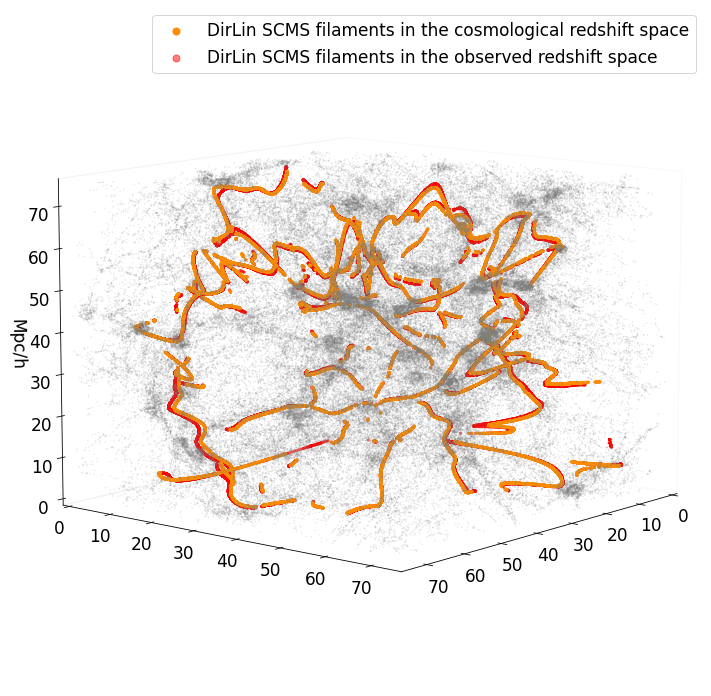

In [19]:
## FOF halos in the true redshift space
X_halo = WMAP9.h * WMAP9.comoving_distance(mock_dat_z0['z_true']).value * np.cos(mock_dat_z0['RA']/180*np.pi) * np.cos(mock_dat_z0['DEC']/180*np.pi)
Y_halo = WMAP9.h * WMAP9.comoving_distance(mock_dat_z0['z_true']).value * np.sin(mock_dat_z0['RA']/180*np.pi) * np.cos(mock_dat_z0['DEC']/180*np.pi)
Z_halo = WMAP9.h * WMAP9.comoving_distance(mock_dat_z0['z_true']).value * np.sin(mock_dat_z0['DEC']/180*np.pi)

## Filaments in the true redshift space
RA_f_cos, DEC_f_cos, R = cart2sph(*DirLinFila_cos[:,:3].T)

X_f_cos = DirLinFila_cos[:,3] * np.cos(RA_f_cos/180*np.pi) * np.cos(DEC_f_cos/180*np.pi)
Y_f_cos = DirLinFila_cos[:,3] * np.sin(RA_f_cos/180*np.pi) * np.cos(DEC_f_cos/180*np.pi)
Z_f_cos = DirLinFila_cos[:,3] * np.sin(DEC_f_cos/180*np.pi)

X_f_cos_comov = WMAP9.h * WMAP9.comoving_distance(X_f_cos).value
Y_f_cos_comov = WMAP9.h * WMAP9.comoving_distance(Y_f_cos).value
Z_f_cos_comov = WMAP9.h * WMAP9.comoving_distance(Z_f_cos).value

DirLinFila_cos_3D_comov = np.vstack((X_f_cos_comov, Y_f_cos_comov, Z_f_cos_comov)).T

## Filaments in the true/cosmological redshift space
RA_f_obs, DEC_f_obs, R = cart2sph(*DirLinFila_obs[:,:3].T)

X_f_obs = DirLinFila_obs[:,3] * np.cos(RA_f_obs/180*np.pi) * np.cos(DEC_f_obs/180*np.pi)
Y_f_obs = DirLinFila_obs[:,3] * np.sin(RA_f_obs/180*np.pi) * np.cos(DEC_f_obs/180*np.pi)
Z_f_obs = DirLinFila_obs[:,3] * np.sin(DEC_f_obs/180*np.pi)

X_f_obs_comov = WMAP9.h * WMAP9.comoving_distance(X_f_obs).value
Y_f_obs_comov = WMAP9.h * WMAP9.comoving_distance(Y_f_obs).value
Z_f_obs_comov = WMAP9.h * WMAP9.comoving_distance(Z_f_obs).value

DirLinFila_obs_3D_comov = np.vstack((X_f_obs_comov, Y_f_obs_comov, Z_f_obs_comov)).T

plt.rcParams.update({'font.size': 17})  # Change the font sizes of ouput figures
# 0.75*h, 60*b
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.view_init(10, 40)
# ax.scatter3D(X_halo, Y_halo, Z_halo, color='dodgerblue', alpha=0.2, s=0.1, 
#              label='FOF halo in the true redshift space')
ax.scatter3D(X_halo, Y_halo, Z_halo, color='grey', alpha=0.3, s=0.1)
ax.scatter3D(X_f_cos_comov, Y_f_cos_comov, Z_f_cos_comov, color='darkorange', alpha=1, s=5, 
             label='DirLin SCMS filaments in the cosmological redshift space')
ax.scatter3D(X_f_obs_comov, Y_f_obs_comov, Z_f_obs_comov, color='red', alpha=0.5, s=5, 
             label='DirLin SCMS filaments in the observed redshift space')
# ax.set_xlabel('Mpc/h')
# ax.set_ylabel('Mpc/h')
ax.set_zlabel('Mpc/h')
lgnd = plt.legend(numpoints=1)
# change the marker size manually for both lines
lgnd.legendHandles[0]._sizes = [50]
lgnd.legendHandles[1]._sizes = [50]
# plt.title('DirLin SCMS: 0.75*h, 60*b')
ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

ax.grid(False)
ax.set_xlim(0, 75)
ax.set_ylim(0, 75)
ax.set_zlim(0, 75)
plt.tight_layout()
fig.savefig('./Figures/DirLin_illustris.jpg', bbox_inches="tight", dpi=150)
# plt.show()

#### Distances between the DirLin SCMS filament in the observed redshift space and the one in the true/cosmological redshift space

In [20]:
def DistToFila(x, tar_fila):
    x = x.values
    return min(LA.norm(tar_fila - x, axis=1))

@ray.remote
def DistToFila_Fs(pts, tar_fila):
    dist = np.zeros((pts.shape[0], ))
    for i in range(pts.shape[0]):
        dist[i] = min(LA.norm(tar_fila - pts[i,:], axis=1))
    return dist

In [ ]:
fac_lst = [(1, 50), (1, 60), (1, 70), (1, 75), (1, 80), (1, 85), (1, 90), 
           (0.75, 40), (0.75, 50), (0.75, 55), (0.75, 60), (0.75, 65), (0.75, 70), (0.75, 80), 
           (0.5, 20), (0.5, 30), (0.5, 35), (0.5, 40), (0.5, 45), (0.5, 50), (0.5, 60)]
for fac_h, fac_b in fac_lst:
    print((fac_h, fac_b))
    
    ### Loading the DirLin filaments in the observed redshift space
    with open("./Theory_Method_Results/Illustris_Data/Illustris_DirLinSCMS_z0_"+str(fac_h)+"h_"+str(fac_b)+"b.dat", "rb") as file:
        bw_Dir, bw_Lin, DirLinFila_obs = pickle.load(file)
    print(DirLinFila_obs.shape)
    
    print(sum(DirLinFila_obs[:,4] == 1))
    print(sum(DirLinFila_obs[:,3] < max(mock_dat_z0['z_obs'])))
    print(sum(DirLinFila_obs[:,3] > min(mock_dat_z0['z_obs'])))
    DirLinFila_obs = DirLinFila_obs[(DirLinFila_obs[:,4] == 1) & (DirLinFila_obs[:,3] < max(mock_dat_z0['z_obs'])) & (DirLinFila_obs[:,3] > min(mock_dat_z0['z_obs']))]
    
    
    ### Loading the DirLin filaments in the true/cosmological redshift space
    with open("./Data_Outputs/Illustris_Data/Illustris_DirLinSCMS_z0_"+str(fac_h)+"h_"+str(fac_b)+"b_true.dat", "rb") as file:
        bw_Dir, bw_Lin, DirLinFila_cos = pickle.load(file)
    print(DirLinFila_cos.shape)
    
    print(sum(DirLinFila_cos[:,4] == 1))
    print(sum(DirLinFila_cos[:,3] < max(mock_dat_z0['z_true'])))
    print(sum(DirLinFila_cos[:,3] > min(mock_dat_z0['z_true'])))
    DirLinFila_cos = DirLinFila_cos[(DirLinFila_cos[:,4] == 1) & (DirLinFila_cos[:,3] < max(mock_dat_z0['z_true'])) & (DirLinFila_cos[:,3] > min(mock_dat_z0['z_true']))]
    
    ## Filaments in the true redshift space
    RA_f_cos, DEC_f_cos, R = cart2sph(*DirLinFila_cos[:,:3].T)
    
    X_f_cos = DirLinFila_cos[:,3] * np.cos(RA_f_cos/180*np.pi) * np.cos(DEC_f_cos/180*np.pi)
    Y_f_cos = DirLinFila_cos[:,3] * np.sin(RA_f_cos/180*np.pi) * np.cos(DEC_f_cos/180*np.pi)
    Z_f_cos = DirLinFila_cos[:,3] * np.sin(DEC_f_cos/180*np.pi)
    
    X_f_cos_comov = WMAP9.h * WMAP9.comoving_distance(X_f_cos).value
    Y_f_cos_comov = WMAP9.h * WMAP9.comoving_distance(Y_f_cos).value
    Z_f_cos_comov = WMAP9.h * WMAP9.comoving_distance(Z_f_cos).value
    
    DirLinFila_cos_3D = np.vstack((X_f_cos, Y_f_cos, Z_f_cos)).T
    DirLinFila_cos_3D_comov = np.vstack((X_f_cos_comov, Y_f_cos_comov, Z_f_cos_comov)).T
    
    # Filaments in the observed redshift space
    RA_f_obs, DEC_f_obs, R = cart2sph(*DirLinFila_obs[:,:3].T)
    
    X_f_obs = DirLinFila_obs[:,3] * np.cos(RA_f_obs/180*np.pi) * np.cos(DEC_f_obs/180*np.pi)
    Y_f_obs = DirLinFila_obs[:,3] * np.sin(RA_f_obs/180*np.pi) * np.cos(DEC_f_obs/180*np.pi)
    Z_f_obs = DirLinFila_obs[:,3] * np.sin(DEC_f_obs/180*np.pi)
    
    X_f_obs_comov = WMAP9.h * WMAP9.comoving_distance(X_f_obs).value
    Y_f_obs_comov = WMAP9.h * WMAP9.comoving_distance(Y_f_obs).value
    Z_f_obs_comov = WMAP9.h * WMAP9.comoving_distance(Z_f_obs).value
    
    DirLinFila_obs_3D = np.vstack((X_f_obs, Y_f_obs, Z_f_obs)).T
    DirLinFila_obs_3D_comov = np.vstack((X_f_obs_comov, Y_f_obs_comov, Z_f_obs_comov)).T
    
    ray.init()
    chunksize = 20
    data = DirLinFila_obs_3D_comov
    num_p = data.shape[0]
    result_ids = []
    for i in range(0, num_p, chunksize):
        result_ids.append(DistToFila_Fs.remote(data[i:(i+chunksize)], tar_fila=DirLinFila_cos_3D_comov))
    DirLin_obs_to_cos_comov = ray.get(result_ids)
    DirLin_obs_to_cos_comov = np.concatenate(DirLin_obs_to_cos_comov, axis=0)
    ray.shutdown()
    
    ray.init()
    chunksize = 20
    data = DirLinFila_cos_3D_comov
    num_p = data.shape[0]
    result_ids = []
    for i in range(0, num_p, chunksize):
        result_ids.append(DistToFila_Fs.remote(data[i:(i+chunksize)], tar_fila=DirLinFila_obs_3D_comov))
    DirLin_cos_to_obs_comov = ray.get(result_ids)
    DirLin_cos_to_obs_comov = np.concatenate(DirLin_cos_to_obs_comov, axis=0)
    ray.shutdown()
    
    with open("./Data_Outputs/Illustris_Data/dist_diff_DirLinSCMS_obs_cos_z0_"+str(fac_h)+"h_"+str(fac_b)+"b_comov.dat", "wb") as file:
        pickle.dump([DirLin_obs_to_cos_comov, DirLin_cos_to_obs_comov], file)

#### Halo number density (DirLin SCMS method)

In [21]:
## FOF halos in the observed redshift space
X_halo = WMAP9.h * WMAP9.comoving_distance(mock_dat_z0['z_obs']).value * np.cos(mock_dat_z0['RA']/180*np.pi) * np.cos(mock_dat_z0['DEC']/180*np.pi)
Y_halo = WMAP9.h * WMAP9.comoving_distance(mock_dat_z0['z_obs']).value * np.sin(mock_dat_z0['RA']/180*np.pi) * np.cos(mock_dat_z0['DEC']/180*np.pi)
Z_halo = WMAP9.h * WMAP9.comoving_distance(mock_dat_z0['z_obs']).value * np.sin(mock_dat_z0['DEC']/180*np.pi)

# The unit is Mpc/h
halo_pos = np.vstack((X_halo, Y_halo, Z_halo)).T

## FOF halos in the true redshift space
X_halo_true = WMAP9.h * WMAP9.comoving_distance(mock_dat_z0['z_true']).value * np.cos(mock_dat_z0['RA']/180*np.pi) * np.cos(mock_dat_z0['DEC']/180*np.pi)
Y_halo_true = WMAP9.h * WMAP9.comoving_distance(mock_dat_z0['z_true']).value * np.sin(mock_dat_z0['RA']/180*np.pi) * np.cos(mock_dat_z0['DEC']/180*np.pi)
Z_halo_true = WMAP9.h * WMAP9.comoving_distance(mock_dat_z0['z_true']).value * np.sin(mock_dat_z0['DEC']/180*np.pi)

halo_pos_true = np.vstack((X_halo_true, Y_halo_true, Z_halo_true)).T

In [22]:
def GalaxyNumDenst(pt, gal_dat):
    pt = pt.values
    return sum(LA.norm(gal_dat - pt, axis=1) <= 0.001)

@ray.remote
def GalaxyNumDenst_Fs(fila_pt, gal_dat, thres_val=0.001):
    gal_nd = np.zeros((fila_pt.shape[0], ))
    for i in range(fila_pt.shape[0]):
        gal_nd[i] = sum(LA.norm(gal_dat -fila_pt[i,:], axis=1) <= thres_val)
    return gal_nd

In [ ]:
fac_lst = [(1, 50), (1, 60), (1, 70), (1, 75), (1, 80), (1, 85), (1, 90), 
           (0.75, 40), (0.75, 50), (0.75, 55), (0.75, 60), (0.75, 65), (0.75, 70), (0.75, 80), 
           (0.5, 20), (0.5, 30), (0.5, 35), (0.5, 40), (0.5, 45), (0.5, 50), (0.5, 60)]
for fac_h, fac_b in fac_lst:
    print((fac_h, fac_b))
    
    ### Loading the DirLin filaments
    with open("./Data_Outputs/Illustris_Data/Illustris_DirLinSCMS_z0_"+str(fac_h)+"h_"+str(fac_b)+"b.dat", "rb") as file:
        bw_Dir, bw_Lin, DirLinFila_obs = pickle.load(file)
    print(DirLinFila_obs.shape)
    
    print(sum(DirLinFila_obs[:,4] == 1))
    print(sum(DirLinFila_obs[:,3] < max(mock_dat_z0['z_obs'])))
    print(sum(DirLinFila_obs[:,3] > min(mock_dat_z0['z_obs'])))
    DirLinFila_obs = DirLinFila_obs[(DirLinFila_obs[:,4] == 1) & (DirLinFila_obs[:,3] < max(mock_dat_z0['z_obs'])) & (DirLinFila_obs[:,3] > min(mock_dat_z0['z_obs']))]
    
    RA_f_obs, DEC_f_obs, R = cart2sph(*DirLinFila_obs[:,:3].T)
    
    X_f_obs = DirLinFila_obs[:,3] * np.cos(RA_f_obs/180*np.pi) * np.cos(DEC_f_obs/180*np.pi)
    Y_f_obs = DirLinFila_obs[:,3] * np.sin(RA_f_obs/180*np.pi) * np.cos(DEC_f_obs/180*np.pi)
    Z_f_obs = DirLinFila_obs[:,3] * np.sin(DEC_f_obs/180*np.pi)
    
    X_f_obs_comov = WMAP9.h * WMAP9.comoving_distance(X_f_obs).value
    Y_f_obs_comov = WMAP9.h * WMAP9.comoving_distance(Y_f_obs).value
    Z_f_obs_comov = WMAP9.h * WMAP9.comoving_distance(Z_f_obs).value
    
    DirLinFila_obs_3D = np.vstack((X_f_obs, Y_f_obs, Z_f_obs)).T
    DirLinFila_obs_3D_comov = np.vstack((X_f_obs_comov, Y_f_obs_comov, Z_f_obs_comov)).T
    
    start = time.time()
    ray.init()
    chunksize = 10
    fila_data = DirLinFila_obs_3D_comov
    num_p = fila_data.shape[0]
    result_ids = []
    for i in range(0, num_p, chunksize):
        result_ids.append(GalaxyNumDenst_Fs.remote(fila_data[i:(i+chunksize)], gal_dat=halo_pos, thres_val=3))
    gnd_DirLin = ray.get(result_ids)
    gnd_DirLin = np.concatenate(gnd_DirLin, axis=0)
    ray.shutdown()
    print("Elasped time: "+ str(time.time()-start)+'s.\n')
    
    with open("./Data_Outputs/Illustris_Data/GND_DirLinSCMS_z0_"+str(fac_h)+"h_"+str(fac_b)+"b.dat", "wb") as file:
        pickle.dump(gnd_DirLin, file)

#### Halo number density (Halos themselves)

In [ ]:
start = time.time()
ray.init()
chunksize = 10
fila_data = halo_pos_true
num_p = fila_data.shape[0]
result_ids = []
for i in range(0, num_p, chunksize):
    result_ids.append(GalaxyNumDenst_Fs.remote(fila_data[i:(i+chunksize)], gal_dat=halo_pos, thres_val=3))
gnd_halo_true = ray.get(result_ids)
gnd_halo_true = np.concatenate(gnd_halo_true, axis=0)
ray.shutdown()
print("Elasped time: "+ str(time.time()-start)+'s.\n')

with open("./Data_Outputs/Illustris_Data/GND_halo_z0_true.dat", "wb") as file:
    pickle.dump(gnd_halo_true, file)
    
start = time.time()
ray.init()
chunksize = 10
fila_data = halo_pos
num_p = fila_data.shape[0]
result_ids = []
for i in range(0, num_p, chunksize):
    result_ids.append(GalaxyNumDenst_Fs.remote(fila_data[i:(i+chunksize)], gal_dat=halo_pos, thres_val=3))
gnd_halo = ray.get(result_ids)
gnd_halo = np.concatenate(gnd_halo, axis=0)
ray.shutdown()
print("Elasped time: "+ str(time.time()-start)+'s.\n')

with open("./Data_Outputs/Illustris_Data/GND_halo_z0_obs.dat", "wb") as file:
    pickle.dump(gnd_halo, file)

#### Prepare the data format of which the DisPerSE code can read: http://www2.iap.fr/users/sousbie/web/html/index744c.html?post/survey_ascii-format

In [23]:
from astropy.io import ascii

halo_obs = mock_dat_z0[['RA', 'DEC', 'z_obs']]
halo_obs.columns = ['ra', 'dec', 'z']
halo_obs_tab = Table.from_pandas(halo_obs)

# Output the file for which the DisPerSE code can read.
ascii.write(halo_obs_tab, './Data_Outputs/Disperse_IO_files/Illustris_z0_halo_obs.survey_ascii', 
            overwrite=True, comment=False)

halo_cos = mock_dat_z0[['RA', 'DEC', 'z_true']]
halo_cos.columns = ['ra', 'dec', 'z']
halo_cos_tab = Table.from_pandas(halo_cos)

# Output the file for which the DisPerSE code can read.
ascii.write(halo_cos_tab, './Data_Outputs/Disperse_IO_files/Illustris_z0_halo_cos.survey_ascii', 
            overwrite=True, comment=False)

### Run the DisPerSE code on the 3D (ra, dec, observed redshift) space under the WMAP-9 cosmology

In [28]:
!../../disperse/bin/delaunay_3D ./Data_Outputs/Disperse_IO_files/Illustris_z0_halo_obs.survey_ascii \
-outName ./Data_Outputs/Disperse_IO_files/Illustris_z0_halo_obs -btype smooth \
-cosmo 0.286 0.714 0.00 0.693 -1.00



Initialized cosmo distances: Om=0.29 Ol=0.71 Ok=0.00 h=0.69 w=-1.00.
reading ./Data_Outputs/Disperse_IO_files/Illustris_z0_halo_obs.survey_ascii (ASCII) ... done. (131727 lines)
Margin set to 0.0958555 (actual size is ~11.5926).
Tesselating 131727 particles (3D) ... (+0 in boundary) done. (0.66s elapsed)
Circumsphere test was skipped.
Computing density ... done.
Building smooth boundaries (816 guards):  tesselation ...  generating ... cleaning up ... done. (+28986 particles)
Adding 28986 particles ... done.
Computing density ... done.
All done in 1.44 s.
Converting tesselation to NDnetwork ... done.
Will write network to file './Data_Outputs/Disperse_IO_files/Illustris_z0_halo_obs.NDnet'.
All done.

Network was saved as : ./Data_Outputs/Disperse_IO_files/Illustris_z0_halo_obs.NDnet
   comment: 'Om=0.29 Ol=0.71 Ok=0.00 h=0.69 w=-1.00'
   3D-Network has 142369 vertices.
   periodicity: non-periodic.
   Available faces: 1067865 1-F, 1841443 2-F, 905127 3-F.
   Bounding box: x0=[-0.57381

In [36]:
!../../disperse/bin/mse ./Data_Outputs/Disperse_IO_files/Illustris_z0_halo_obs.NDnet \
-outName ./Data_Outputs/Disperse_IO_files/Illustris_z0_halo_obs -periodicity 0 -nsig 9 -forceLoops -upSkl


****** MSE v0.9.24 (64 bits) ******
Will read network from file './Data_Outputs/Disperse_IO_files/Illustris_z0_halo_obs.NDnet'.
Loading 3D network from file "./Data_Outputs/Disperse_IO_files/Illustris_z0_halo_obs.NDnet" ... done.
Computing 3-faces lists for vertice ... done.
Computing 2-faces lists for vertice ... done.
Computing 1-faces lists for vertice ... done.
Building mask ... done. (33785 2-faces on boundary)
*********************************
Starting Morse-Smale complex computation.
Computing discrete gradient for 3956804 cells:
   Identifying (2,3)-cell pairs:
      Sorting 1841443 2-cells (asc.) ... done.
      Computing MST ... (components) done.(847/905127 comp.)
      Computing discrete Gradient (847 comp.) ... done.
   Identifying (1,0)-cell pairs:
      Sorting 1067865 1-cells (desc.) ... done.
      Computing MST ... (components) done.(20490/142369 comp.)
      Computing discrete Gradient (20490 comp.) ... done.
   Identifying (1,2)-cell pairs:
      Computing saddle-s

In [39]:
!../../disperse/bin/skelconv ./Data_Outputs/Disperse_IO_files/Illustris_z0_halo_obs_s9.up.NDskl \
-outName ./Data_Outputs/Disperse_IO_files/Illustris_z0_halo_obs_s9.up \
-smooth 5 -breakdown -assemble 75 -toRaDecZ -cosmo 0.286 0.714 0.00 0.693 -1.00 -to NDskl_ascii


Initialized cosmo distances: Om=0.29 Ol=0.71 Ok=0.00 h=0.69 w=-1.00.
Will read skeleton from file './Data_Outputs/Disperse_IO_files/Illustris_z0_halo_obs_s9.up.NDskl'.
Loading 3D skeleton from file ./Data_Outputs/Disperse_IO_files/Illustris_z0_halo_obs_s9.up.NDskl ... done.
Smoothing skeleton 5 times ... done.
Breaking down skeleton ... done.
Broken down skeleton has 253(+34) nodes and 3799(-12974) segments.
Assembling skeleton ... done. (found 39 filaments)
Processing ...done.
Trimming skeleton ...done.
Assembled skeleton: 68(-185) nodes and 3779(-20) segments left.
Will write skeleton to file './Data_Outputs/Disperse_IO_files/Illustris_z0_halo_obs_s9.up.S005.BRK.ASMB.RaDecZ.a.NDskl'.
Saving 3D skeleton to ASCII file ./Data_Outputs/Disperse_IO_files/Illustris_z0_halo_obs_s9.up.S005.BRK.ASMB.RaDecZ.a.NDskl ... done.


### Run the DisPerSE code on the 3D (ra, dec, cosmological/true redshift) space under the WMAP-9 cosmology

In [31]:
!../../disperse/bin/delaunay_3D ./Data_Outputs/Disperse_IO_files/Illustris_z0_halo_cos.survey_ascii \
-outName ./Data_Outputs/Disperse_IO_files/Illustris_z0_halo_cos -btype smooth \
-cosmo 0.286 0.714 0.00 0.693 -1.00



Initialized cosmo distances: Om=0.29 Ol=0.71 Ok=0.00 h=0.69 w=-1.00.
reading ./Data_Outputs/Disperse_IO_files/Illustris_z0_halo_cos.survey_ascii (ASCII) ... done. (131727 lines)
Margin set to 0.0982667 (actual size is ~10.7396).
Tesselating 131727 particles (3D) ... (+0 in boundary) done. (0.82s elapsed)
Circumsphere test was skipped.
Computing density ... done.
Building smooth boundaries (864 guards):  tesselation ...  generating ... cleaning up ... done. (+41018 particles)
Adding 41018 particles ... done.
Computing density ... done.
All done in 1.77 s.
Converting tesselation to NDnetwork ... done.
Will write network to file './Data_Outputs/Disperse_IO_files/Illustris_z0_halo_cos.NDnet'.
All done.

Network was saved as : ./Data_Outputs/Disperse_IO_files/Illustris_z0_halo_cos.NDnet
   comment: 'Om=0.29 Ol=0.71 Ok=0.00 h=0.69 w=-1.00'
   3D-Network has 145650 vertices.
   periodicity: non-periodic.
   Available faces: 1087243 1-F, 1870754 2-F, 915049 3-F.
   Bounding box: x0=[-0.53160

In [40]:
!../../disperse/bin/mse ./Data_Outputs/Disperse_IO_files/Illustris_z0_halo_cos.NDnet \
-outName ./Data_Outputs/Disperse_IO_files/Illustris_z0_halo_cos -periodicity 0 -nsig 9 -forceLoops -upSkl


****** MSE v0.9.24 (64 bits) ******
Will read network from file './Data_Outputs/Disperse_IO_files/Illustris_z0_halo_cos.NDnet'.
Loading 3D network from file "./Data_Outputs/Disperse_IO_files/Illustris_z0_halo_cos.NDnet" ... done.
Computing 3-faces lists for vertice ... done.
Computing 2-faces lists for vertice ... done.
Computing 1-faces lists for vertice ... done.
Building mask ... done. (40761 2-faces on boundary)
*********************************
Starting Morse-Smale complex computation.
Computing discrete gradient for 4018696 cells:
   Identifying (2,3)-cell pairs:
      Sorting 1870754 2-cells (asc.) ... done.
      Computing MST ... (components) done.(925/915049 comp.)
      Computing discrete Gradient (925 comp.) ... done.
   Identifying (1,0)-cell pairs:
      Sorting 1087243 1-cells (desc.) ... done.
      Computing MST ... (components) done.(21552/145650 comp.)
      Computing discrete Gradient (21552 comp.) ... done.
   Identifying (1,2)-cell pairs:
      Computing saddle-s

In [41]:
!../../disperse/bin/skelconv ./Data_Outputs/Disperse_IO_files/Illustris_z0_halo_cos_s9.up.NDskl \
-outName ./Data_Outputs/Disperse_IO_files/Illustris_z0_halo_cos_s9.up \
-smooth 5 -breakdown -assemble 75 -toRaDecZ -cosmo 0.286 0.714 0.00 0.693 -1.00 -to NDskl_ascii


Initialized cosmo distances: Om=0.29 Ol=0.71 Ok=0.00 h=0.69 w=-1.00.
Will read skeleton from file './Data_Outputs/Disperse_IO_files/Illustris_z0_halo_cos_s9.up.NDskl'.
Loading 3D skeleton from file ./Data_Outputs/Disperse_IO_files/Illustris_z0_halo_cos_s9.up.NDskl ... done.
Smoothing skeleton 5 times ... done.
Breaking down skeleton ... done.
Broken down skeleton has 370(+59) nodes and 4941(-23797) segments.
Assembling skeleton ... done. (found 60 filaments)
Processing ...done.
Trimming skeleton ...done.
Assembled skeleton: 114(-256) nodes and 4887(-54) segments left.
Will write skeleton to file './Data_Outputs/Disperse_IO_files/Illustris_z0_halo_cos_s9.up.S005.BRK.ASMB.RaDecZ.a.NDskl'.
Saving 3D skeleton to ASCII file ./Data_Outputs/Disperse_IO_files/Illustris_z0_halo_cos_s9.up.S005.BRK.ASMB.RaDecZ.a.NDskl ... done.


In [42]:
def read_skl(file, dim=3):
    i = 3
    line = 'start'
    while line != '[FILAMENTS]':
        line = np.loadtxt(file, skiprows=i, max_rows=1, usecols=0, dtype=str)
        i += 1
        
    n_fil = int(np.loadtxt(file, skiprows=i, max_rows=1, dtype=int))
    
    fil_id = np.zeros(0, dtype=int)
    fil_tracers = np.empty(shape=(0,dim), dtype=float)
    count = 1
    for j in range(n_fil):
        n_tracers = int(np.loadtxt(file, skiprows=i+1, max_rows=1, usecols=2, dtype=int))
        filament = np.loadtxt(file, skiprows=i+2, max_rows=n_tracers)
        fil_tracers = np.vstack([fil_tracers, filament])
        fil_id = np.append(fil_id, count*np.ones(n_tracers, dtype=int))
        count += 1
        i += n_tracers + 1
    
    return(n_fil, fil_id, fil_tracers)

In [43]:
disp_fil, fil_id, dis_fila_obs = read_skl('./Data_Outputs/Disperse_IO_files/Illustris_z0_halo_obs_s9.up.S005.BRK.ASMB.RaDecZ.a.NDskl', 
                                         dim=3)
dis_fila_obs = pd.DataFrame(dis_fila_obs)
dis_fila_obs.columns = ['RA', 'DEC', 'Z_obs']

disp_fil, fil_id, dis_fila_cos = read_skl('./Data_Outputs/Disperse_IO_files/Illustris_z0_halo_cos_s9.up.S005.BRK.ASMB.RaDecZ.a.NDskl', 
                                         dim=3)
dis_fila_cos = pd.DataFrame(dis_fila_cos)
dis_fila_cos.columns = ['RA', 'DEC', 'Z_cos']

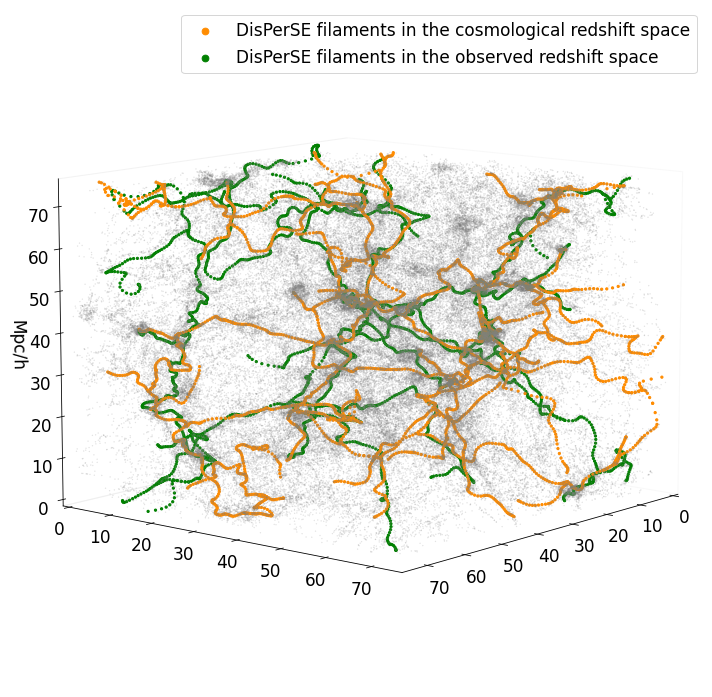

In [44]:
## FOF halos in the true redshift space
X_halo = WMAP9.h * WMAP9.comoving_distance(mock_dat_z0['z_true']).value * np.cos(mock_dat_z0['RA']/180*np.pi) * np.cos(mock_dat_z0['DEC']/180*np.pi)
Y_halo = WMAP9.h * WMAP9.comoving_distance(mock_dat_z0['z_true']).value * np.sin(mock_dat_z0['RA']/180*np.pi) * np.cos(mock_dat_z0['DEC']/180*np.pi)
Z_halo = WMAP9.h * WMAP9.comoving_distance(mock_dat_z0['z_true']).value * np.sin(mock_dat_z0['DEC']/180*np.pi)

## Filaments in the true redshift space
RA_f_cos = dis_fila_cos['RA'].values
DEC_f_cos = dis_fila_cos['DEC'].values

X_f_cos = dis_fila_cos['Z_cos'] * np.cos(RA_f_cos/180*np.pi) * np.cos(DEC_f_cos/180*np.pi)
Y_f_cos = dis_fila_cos['Z_cos'] * np.sin(RA_f_cos/180*np.pi) * np.cos(DEC_f_cos/180*np.pi)
Z_f_cos = dis_fila_cos['Z_cos'] * np.sin(DEC_f_cos/180*np.pi)

X_f_cos_comov = WMAP9.h * WMAP9.comoving_distance(X_f_cos).value
Y_f_cos_comov = WMAP9.h * WMAP9.comoving_distance(Y_f_cos).value
Z_f_cos_comov = WMAP9.h * WMAP9.comoving_distance(Z_f_cos).value

disp_fila_cos_3D = np.vstack((X_f_cos, Y_f_cos, Z_f_cos)).T
disp_fila_cos_3D_comov = np.vstack((X_f_cos_comov, Y_f_cos_comov, Z_f_cos_comov)).T


## Filaments in the observed redshift space
RA_f_obs = dis_fila_obs['RA'].values
DEC_f_obs = dis_fila_obs['DEC'].values


X_f_obs = dis_fila_obs['Z_obs'] * np.cos(RA_f_obs/180*np.pi) * np.cos(DEC_f_obs/180*np.pi)
Y_f_obs = dis_fila_obs['Z_obs'] * np.sin(RA_f_obs/180*np.pi) * np.cos(DEC_f_obs/180*np.pi)
Z_f_obs = dis_fila_obs['Z_obs'] * np.sin(DEC_f_obs/180*np.pi)

X_f_obs_comov = WMAP9.h * WMAP9.comoving_distance(X_f_obs).value
Y_f_obs_comov = WMAP9.h * WMAP9.comoving_distance(Y_f_obs).value
Z_f_obs_comov = WMAP9.h * WMAP9.comoving_distance(Z_f_obs).value

disp_fila_obs_3D = np.vstack((X_f_obs, Y_f_obs, Z_f_obs)).T
disp_fila_obs_3D_comov = np.vstack((X_f_obs_comov, Y_f_obs_comov, Z_f_obs_comov)).T

plt.rcParams.update({'font.size': 17})  # Change the font sizes of ouput figures
# 0.75*h, 60*b
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111, projection='3d')
ax.view_init(10, 40)
# ax.scatter3D(X_halo, Y_halo, Z_halo, color='dodgerblue', alpha=0.2, s=0.1, 
#              label='FOF halo in the true redshift space')
ax.scatter3D(X_halo, Y_halo, Z_halo, color='grey', alpha=0.3, s=0.1)
ax.scatter3D(X_f_cos_comov, Y_f_cos_comov, Z_f_cos_comov, color='darkorange', alpha=1, s=5, 
             label='DisPerSE filaments in the cosmological redshift space')
ax.scatter3D(X_f_obs_comov, Y_f_obs_comov, Z_f_obs_comov, color='green', alpha=1, s=5, 
             label='DisPerSE filaments in the observed redshift space')
# ax.set_xlabel('Mpc/h')
# ax.set_ylabel('Mpc/h')
ax.set_zlabel('Mpc/h')
plt.legend(markerscale=3)

ax.xaxis.pane.fill = False
ax.yaxis.pane.fill = False
ax.zaxis.pane.fill = False

ax.grid(False)
ax.set_xlim(0, 75)
ax.set_ylim(0, 75)
ax.set_zlim(0, 75)
plt.tight_layout()
fig.savefig('./Figures/DisPerSE_illustris.jpg', bbox_inches="tight", dpi=150)
# plt.show()

#### Distances between the DisPerSE filament in the observed redshift space and the one in the true/cosmological redshift space

In [45]:
def DistToFila(x, tar_fila):
    x = x.values
    return min(LA.norm(tar_fila - x, axis=1))

@ray.remote
def DistToFila_Fs(pts, tar_fila):
    dist = np.zeros((pts.shape[0], ))
    for i in range(pts.shape[0]):
        dist[i] = min(LA.norm(tar_fila - pts[i,:], axis=1))
    return dist

In [53]:
for sig in [3, 6, 9, 12]:
    disp_fil, fil_id, dis_fila_obs = read_skl('./Data_Outputs/Disperse_IO_files/Illustris_z0_halo_obs_s'+str(sig)+'.up.S005.BRK.ASMB.RaDecZ.a.NDskl', 
                                             dim=3)
    dis_fila_obs = pd.DataFrame(dis_fila_obs)
    dis_fila_obs.columns = ['RA', 'DEC', 'Z_obs']
    
    disp_fil, fil_id, dis_fila_cos = read_skl('./Data_Outputs/Disperse_IO_files/Illustris_z0_halo_cos_s'+str(sig)+'.up.S005.BRK.ASMB.RaDecZ.a.NDskl', 
                                             dim=3)
    dis_fila_cos = pd.DataFrame(dis_fila_cos)
    dis_fila_cos.columns = ['RA', 'DEC', 'Z_cos']
    
    ## Filaments in the true redshift space
    RA_f_cos = dis_fila_cos['RA'].values
    DEC_f_cos = dis_fila_cos['DEC'].values
    
    X_f_cos = dis_fila_cos['Z_cos'] * np.cos(RA_f_cos/180*np.pi) * np.cos(DEC_f_cos/180*np.pi)
    Y_f_cos = dis_fila_cos['Z_cos'] * np.sin(RA_f_cos/180*np.pi) * np.cos(DEC_f_cos/180*np.pi)
    Z_f_cos = dis_fila_cos['Z_cos'] * np.sin(DEC_f_cos/180*np.pi)
    
    X_f_cos_comov = WMAP9.h * WMAP9.comoving_distance(X_f_cos).value
    Y_f_cos_comov = WMAP9.h * WMAP9.comoving_distance(Y_f_cos).value
    Z_f_cos_comov = WMAP9.h * WMAP9.comoving_distance(Z_f_cos).value
    
    disp_fila_cos_3D = np.vstack((X_f_cos, Y_f_cos, Z_f_cos)).T
    disp_fila_cos_3D_comov = np.vstack((X_f_cos_comov, Y_f_cos_comov, Z_f_cos_comov)).T
    
    
    ## Filaments in the observed redshift space
    RA_f_obs = dis_fila_obs['RA'].values
    DEC_f_obs = dis_fila_obs['DEC'].values
    
    X_f_obs = dis_fila_obs['Z_obs'] * np.cos(RA_f_obs/180*np.pi) * np.cos(DEC_f_obs/180*np.pi)
    Y_f_obs = dis_fila_obs['Z_obs'] * np.sin(RA_f_obs/180*np.pi) * np.cos(DEC_f_obs/180*np.pi)
    Z_f_obs = dis_fila_obs['Z_obs'] * np.sin(DEC_f_obs/180*np.pi)
    
    X_f_obs_comov = WMAP9.h * WMAP9.comoving_distance(X_f_obs).value
    Y_f_obs_comov = WMAP9.h * WMAP9.comoving_distance(Y_f_obs).value
    Z_f_obs_comov = WMAP9.h * WMAP9.comoving_distance(Z_f_obs).value
    
    disp_fila_obs_3D = np.vstack((X_f_obs, Y_f_obs, Z_f_obs)).T
    disp_fila_obs_3D_comov = np.vstack((X_f_obs_comov, Y_f_obs_comov, Z_f_obs_comov)).T
    
    
    ray.init()
    chunksize = 20
    data = disp_fila_obs_3D_comov
    num_p = data.shape[0]
    result_ids = []
    for i in range(0, num_p, chunksize):
        result_ids.append(DistToFila_Fs.remote(data[i:(i+chunksize)], tar_fila=disp_fila_cos_3D_comov))
    disp_obs_to_cos_comov = ray.get(result_ids)
    disp_obs_to_cos_comov = np.concatenate(disp_obs_to_cos_comov, axis=0)
    ray.shutdown()
    
    ray.init()
    chunksize = 20
    data = disp_fila_cos_3D_comov
    num_p = data.shape[0]
    result_ids = []
    for i in range(0, num_p, chunksize):
        result_ids.append(DistToFila_Fs.remote(data[i:(i+chunksize)], tar_fila=disp_fila_obs_3D_comov))
    disp_cos_to_obs_comov = ray.get(result_ids)
    disp_cos_to_obs_comov = np.concatenate(disp_cos_to_obs_comov, axis=0)
    ray.shutdown()
    
    with open("./Data_Outputs/Illustris_Data/dist_diff_Disperse_obs_cos_z0_s"+str(sig)+"_comov.dat", "wb") as file:
        pickle.dump([disp_obs_to_cos_comov, disp_cos_to_obs_comov], file)

2022-07-17 00:14:24,670	INFO services.py:1245 -- View the Ray dashboard at http://127.0.0.1:8265
2022-07-17 00:16:39,556	INFO services.py:1245 -- View the Ray dashboard at http://127.0.0.1:8265
2022-07-17 00:19:00,688	INFO services.py:1245 -- View the Ray dashboard at http://127.0.0.1:8265
2022-07-17 00:19:16,940	INFO services.py:1245 -- View the Ray dashboard at http://127.0.0.1:8265
2022-07-17 00:19:34,001	INFO services.py:1245 -- View the Ray dashboard at http://127.0.0.1:8265
2022-07-17 00:19:39,914	INFO services.py:1245 -- View the Ray dashboard at http://127.0.0.1:8265
2022-07-17 00:19:45,808	INFO services.py:1245 -- View the Ray dashboard at http://127.0.0.1:8265
2022-07-17 00:19:50,356	INFO services.py:1245 -- View the Ray dashboard at http://127.0.0.1:8265


#### Halo Number Density (DisPerSE)

In [24]:
## FOF halos in the true redshift space
X_halo = WMAP9.h * WMAP9.comoving_distance(mock_dat_z0['z_obs']).value * np.cos(mock_dat_z0['RA']/180*np.pi) * np.cos(mock_dat_z0['DEC']/180*np.pi)
Y_halo = WMAP9.h * WMAP9.comoving_distance(mock_dat_z0['z_obs']).value * np.sin(mock_dat_z0['RA']/180*np.pi) * np.cos(mock_dat_z0['DEC']/180*np.pi)
Z_halo = WMAP9.h * WMAP9.comoving_distance(mock_dat_z0['z_obs']).value * np.sin(mock_dat_z0['DEC']/180*np.pi)

# The unit is Mpc/h
halo_pos = np.vstack((X_halo, Y_halo, Z_halo)).T

In [25]:
def GalaxyNumDenst(pt, gal_dat):
    pt = pt.values
    return sum(LA.norm(gal_dat - pt, axis=1) <= 0.001)

@ray.remote
def GalaxyNumDenst_Fs(fila_pt, gal_dat, thres_val=0.001):
    gal_nd = np.zeros((fila_pt.shape[0], ))
    for i in range(fila_pt.shape[0]):
        gal_nd[i] = sum(LA.norm(gal_dat -fila_pt[i,:], axis=1) <= thres_val)
    return gal_nd

In [ ]:
for sig in [3, 6, 9, 12]:
    disp_fil, fil_id, dis_fila_obs = read_skl('./Data_Outputs/Disperse_IO_files/Illustris_z0_halo_obs_s'+str(sig)+'.up.S005.BRK.ASMB.RaDecZ.a.NDskl', 
                                             dim=3)
    dis_fila_obs = pd.DataFrame(dis_fila_obs)
    dis_fila_obs.columns = ['RA', 'DEC', 'Z_obs']
    
    ## Filaments in the observed redshift space
    RA_f_obs = dis_fila_obs['RA'].values
    DEC_f_obs = dis_fila_obs['DEC'].values
    
    X_f_obs = dis_fila_obs['Z_obs'] * np.cos(RA_f_obs/180*np.pi) * np.cos(DEC_f_obs/180*np.pi)
    Y_f_obs = dis_fila_obs['Z_obs'] * np.sin(RA_f_obs/180*np.pi) * np.cos(DEC_f_obs/180*np.pi)
    Z_f_obs = dis_fila_obs['Z_obs'] * np.sin(DEC_f_obs/180*np.pi)
    
    X_f_obs_comov = WMAP9.h * WMAP9.comoving_distance(X_f_obs).value
    Y_f_obs_comov = WMAP9.h * WMAP9.comoving_distance(Y_f_obs).value
    Z_f_obs_comov = WMAP9.h * WMAP9.comoving_distance(Z_f_obs).value
    
    disp_fila_obs_3D = np.vstack((X_f_obs, Y_f_obs, Z_f_obs)).T
    disp_fila_obs_3D_comov = np.vstack((X_f_obs_comov, Y_f_obs_comov, Z_f_obs_comov)).T
    
    start = time.time()
    ray.init()
    chunksize = 10
    fila_data = disp_fila_obs_3D_comov
    num_p = fila_data.shape[0]
    result_ids = []
    for i in range(0, num_p, chunksize):
        result_ids.append(GalaxyNumDenst_Fs.remote(fila_data[i:(i+chunksize)], gal_dat=halo_pos, thres_val=3))
    gnd_disp = ray.get(result_ids)
    gnd_disp = np.concatenate(gnd_disp, axis=0)
    ray.shutdown()
    print("Elasped time: "+ str(time.time()-start)+'s.\n')
    
    with open("./Data_Outputs/Illustris_Data/GND_Disperse_z0_s"+str(sig)+"_comov.dat", "wb") as file:
        pickle.dump(gnd_disp, file)

### Visualizations of DirLin SCMS filaments under different combinations of the bandwidths

(1, 50)
(103275, 5)
103274
103275
103275
(103275, 5)
103275
103275
103275
(1, 60)
(103275, 5)
103274
103275
103275
(103275, 5)
103275
103275
103275
(1, 70)
(103275, 5)
103275
103275
103275
(103275, 5)
103275
103275
103275
(1, 75)
(103275, 5)
103274
103275
103275
(103275, 5)
103274
103275
103275
(1, 80)
(103275, 5)
103275
103275
103275
(103275, 5)
103275
103275
103275
(1, 85)
(103275, 5)
103275
103275
103275
(103275, 5)
103275
103275
103275
(1, 90)
(103275, 5)
103275
103275
103113
(103275, 5)
103275
103275
103122
(0.75, 40)
(103275, 5)
103275
103275
103275
(103275, 5)
103275
103275
103275
(0.75, 50)
(103275, 5)
103275
103275
103275
(103275, 5)
103275
103275
103275
(0.75, 55)
(103275, 5)
103275
103275
103275
(103275, 5)
103275
103275
103275
(0.75, 60)
(103275, 5)
103273
103275
103275
(103275, 5)
103275
103275
103275
(0.75, 65)
(103275, 5)
103274
103275
103264
(103275, 5)
103275
103275
103266
(0.75, 70)
(103275, 5)
103275
103275
103251
(103275, 5)
103274
103275
103255
(0.75, 80)
(103275, 

/tmp/ipykernel_5748/1252199758.py:63: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = plt.figure(figsize=(8,8))


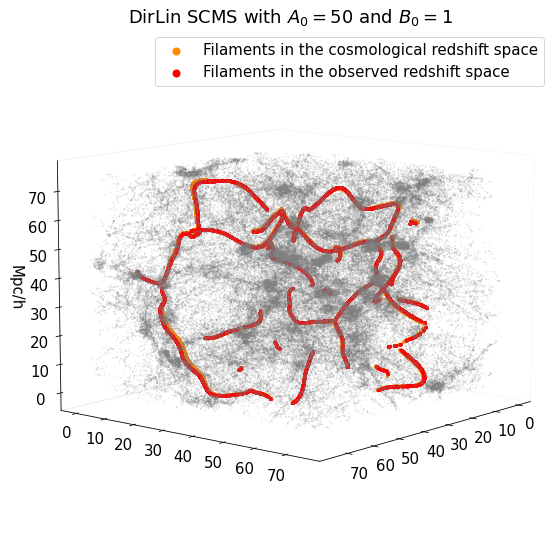

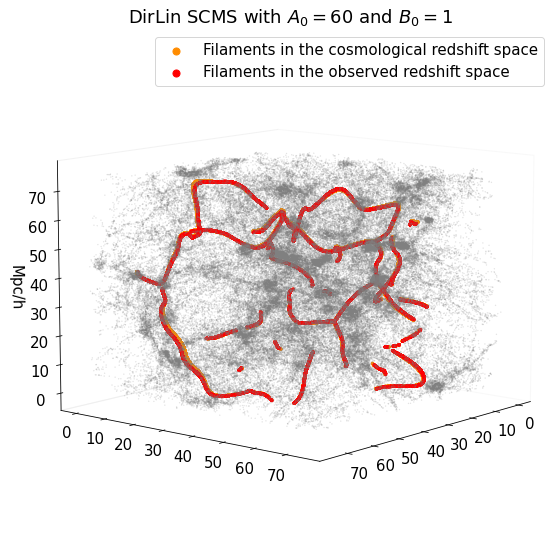

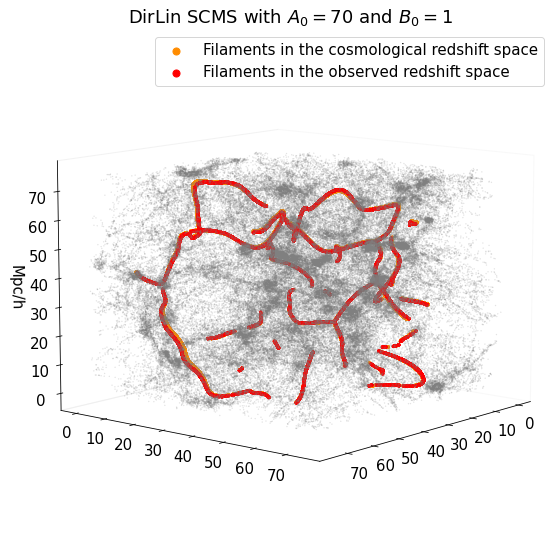

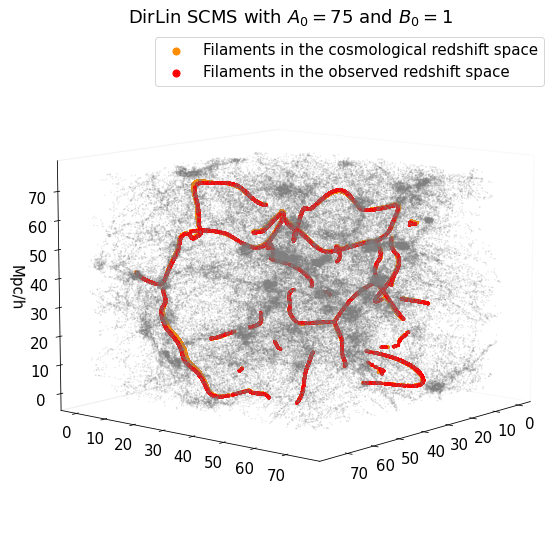

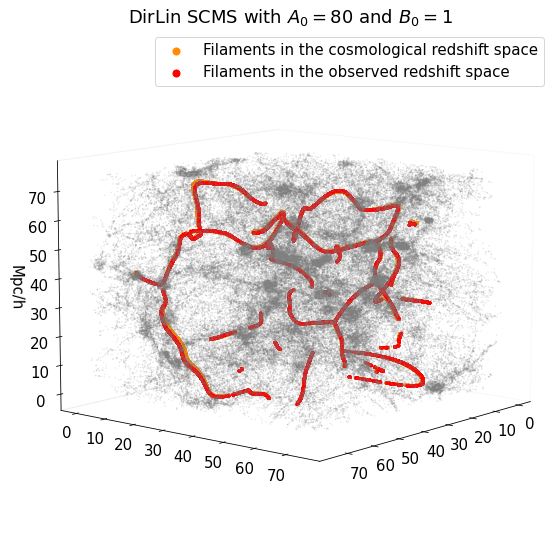

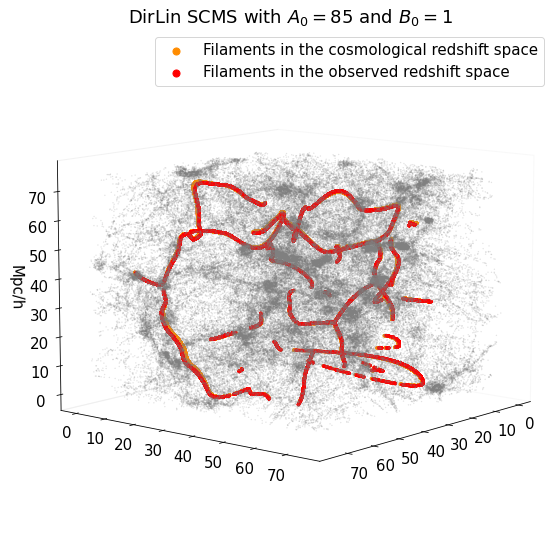

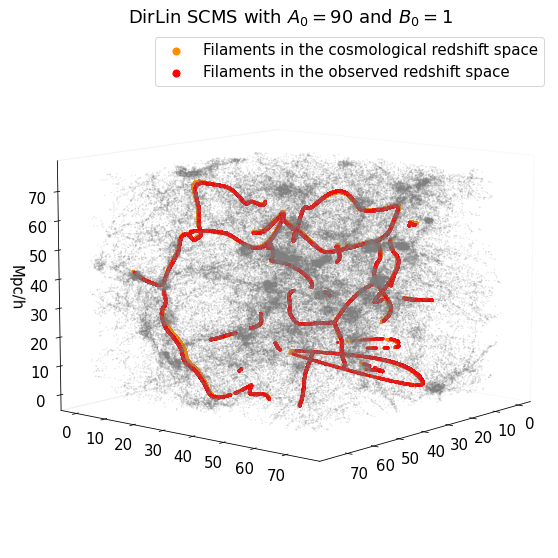

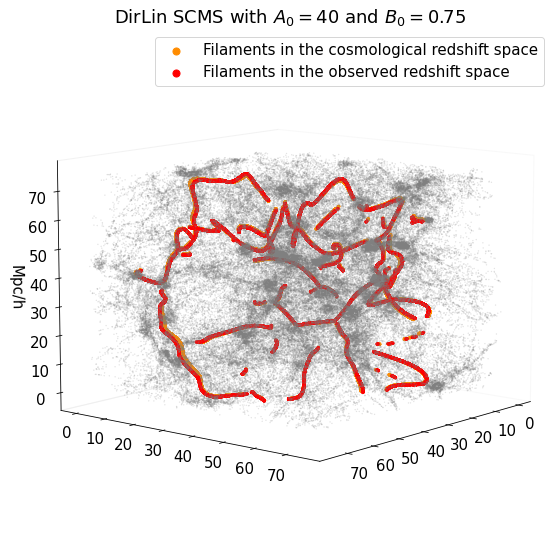

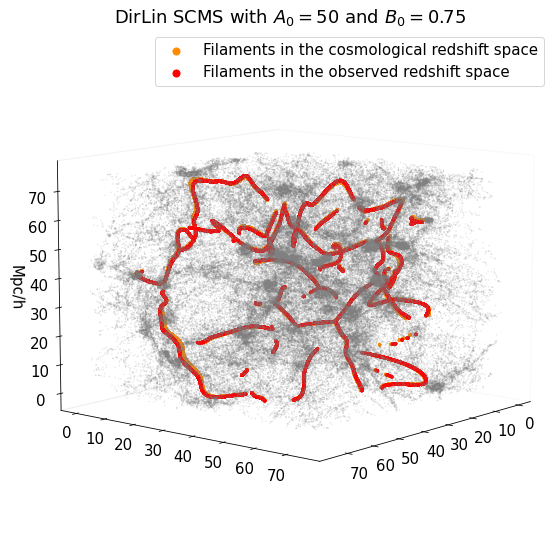

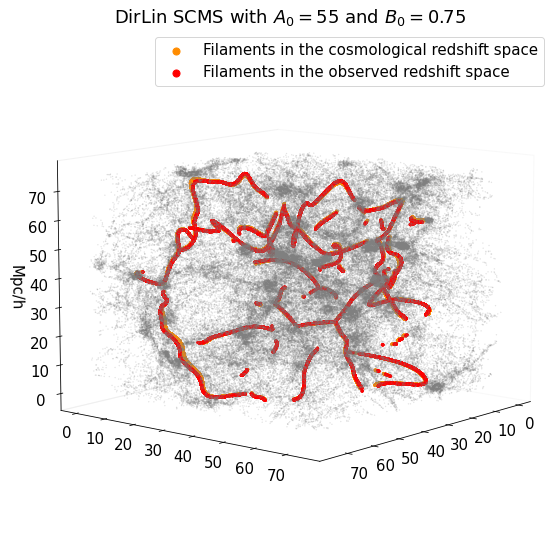

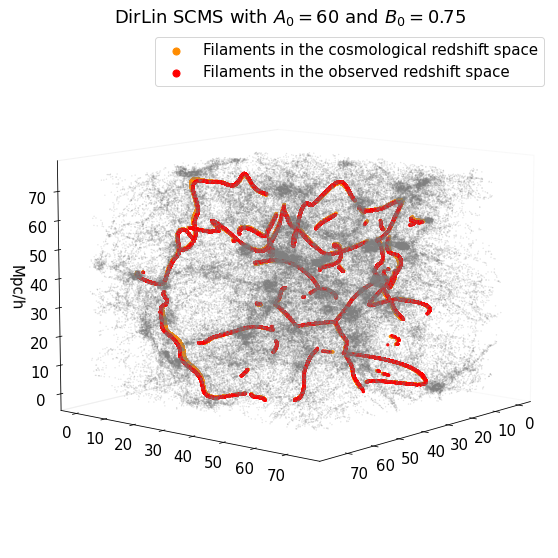

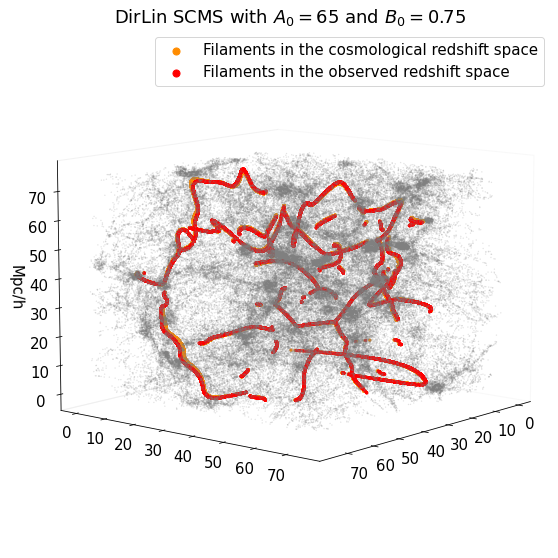

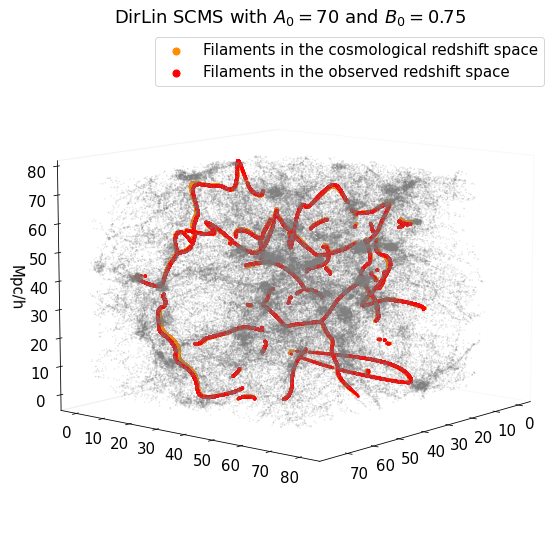

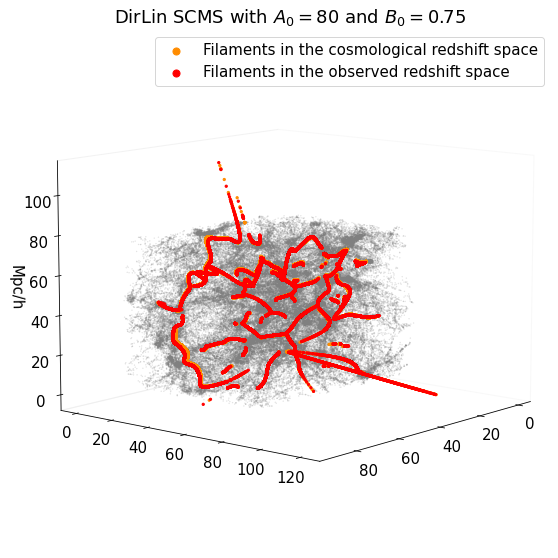

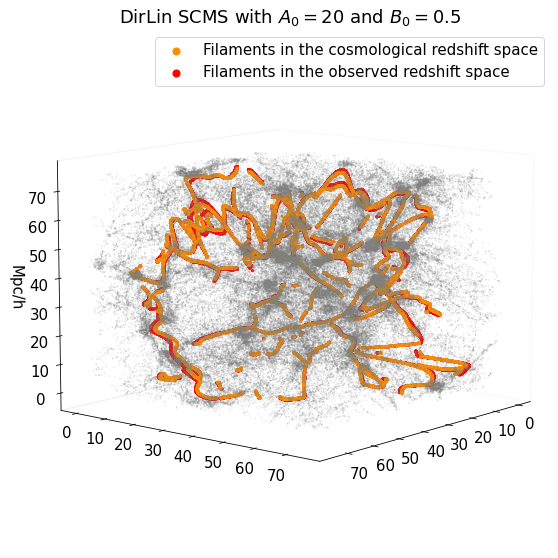

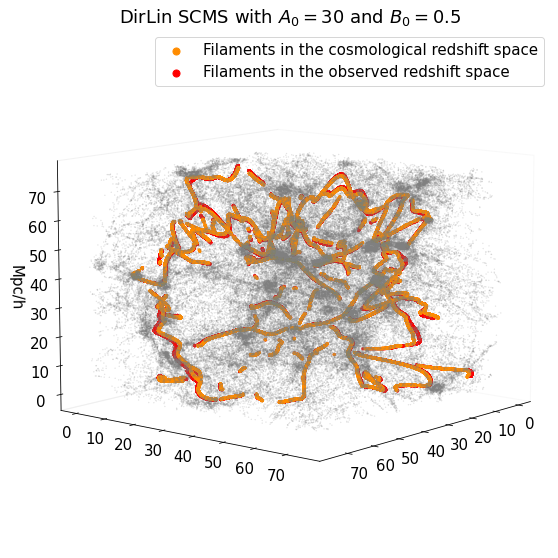

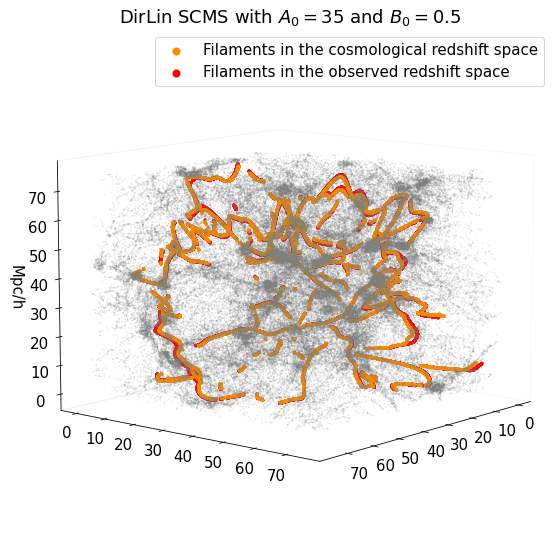

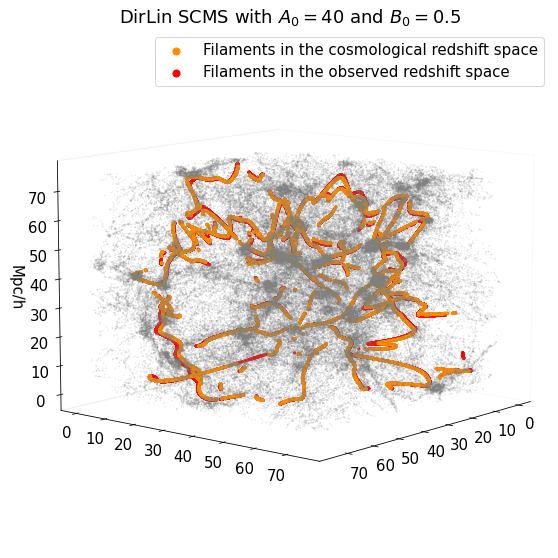

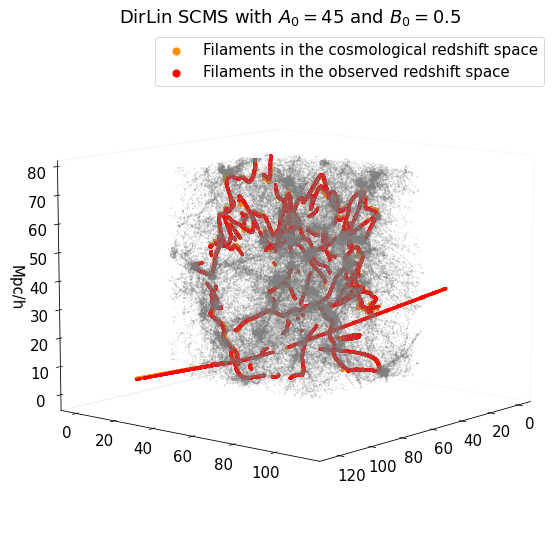

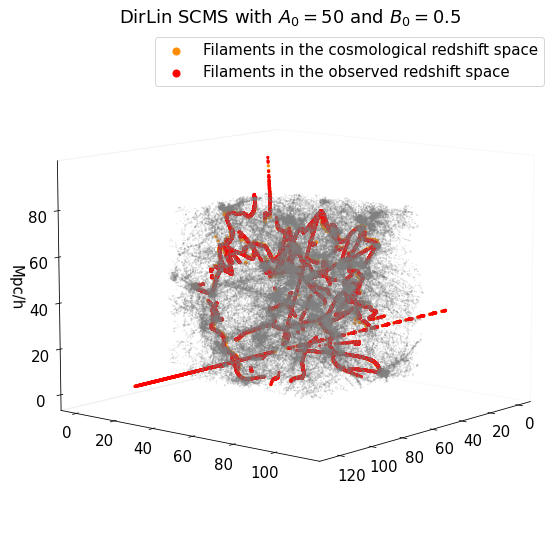

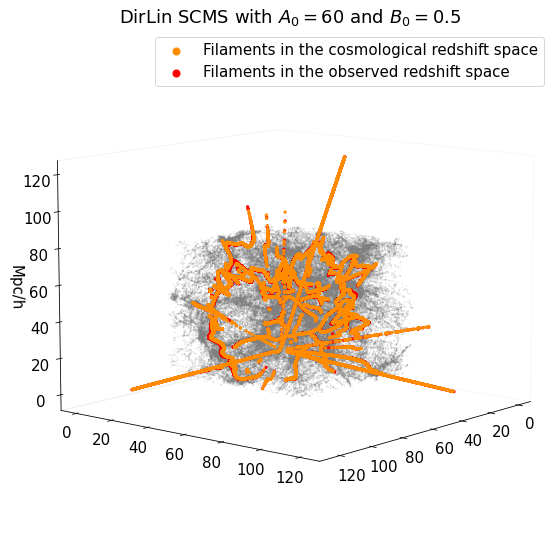

In [54]:
fac_lst = [(1, 50), (1, 60), (1, 70), (1, 75), (1, 80), (1, 85), (1, 90), 
           (0.75, 40), (0.75, 50), (0.75, 55), (0.75, 60), (0.75, 65), (0.75, 70), (0.75, 80), 
           (0.5, 20), (0.5, 30), (0.5, 35), (0.5, 40), (0.5, 45), (0.5, 50), (0.5, 60)]
for fac_h, fac_b in fac_lst:
    print((fac_h, fac_b))
    
    ### Loading the DirLin filaments in the observed redshift space
    with open("./Data_Outputs/Illustris_Data/Illustris_DirLinSCMS_z0_"+str(fac_h)+"h_"+str(fac_b)+"b.dat", "rb") as file:
        bw_Dir, bw_Lin, DirLinFila_obs = pickle.load(file)
    print(DirLinFila_obs.shape)
    
    print(sum(DirLinFila_obs[:,4] == 1))
    print(sum(DirLinFila_obs[:,3] < max(mock_dat_z0['z_obs'])))
    print(sum(DirLinFila_obs[:,3] > min(mock_dat_z0['z_obs'])))
    DirLinFila_obs = DirLinFila_obs[(DirLinFila_obs[:,4] == 1) & (DirLinFila_obs[:,3] < max(mock_dat_z0['z_obs'])) & (DirLinFila_obs[:,3] > min(mock_dat_z0['z_obs']))]
    
    
    ### Loading the DirLin filaments
    with open("./Data_Outputs/Illustris_Data/Illustris_DirLinSCMS_z0_"+str(fac_h)+"h_"+str(fac_b)+"b_true.dat", "rb") as file:
        bw_Dir, bw_Lin, DirLinFila_cos = pickle.load(file)
    print(DirLinFila_cos.shape)
    
    print(sum(DirLinFila_cos[:,4] == 1))
    print(sum(DirLinFila_cos[:,3] < max(mock_dat_z0['z_true'])))
    print(sum(DirLinFila_cos[:,3] > min(mock_dat_z0['z_true'])))
    DirLinFila_cos = DirLinFila_cos[(DirLinFila_cos[:,4] == 1) & (DirLinFila_cos[:,3] < max(mock_dat_z0['z_true'])) & (DirLinFila_cos[:,3] > min(mock_dat_z0['z_true']))]

    
    ## FOF halos in the true redshift space
    X_halo = WMAP9.h * WMAP9.comoving_distance(mock_dat_z0['z_true']).value * np.cos(mock_dat_z0['RA']/180*np.pi) * np.cos(mock_dat_z0['DEC']/180*np.pi)
    Y_halo = WMAP9.h * WMAP9.comoving_distance(mock_dat_z0['z_true']).value * np.sin(mock_dat_z0['RA']/180*np.pi) * np.cos(mock_dat_z0['DEC']/180*np.pi)
    Z_halo = WMAP9.h * WMAP9.comoving_distance(mock_dat_z0['z_true']).value * np.sin(mock_dat_z0['DEC']/180*np.pi)
    
    ## Filaments in the true redshift space
    RA_f_cos, DEC_f_cos, R = cart2sph(*DirLinFila_cos[:,:3].T)
    
    X_f_cos = DirLinFila_cos[:,3] * np.cos(RA_f_cos/180*np.pi) * np.cos(DEC_f_cos/180*np.pi)
    Y_f_cos = DirLinFila_cos[:,3] * np.sin(RA_f_cos/180*np.pi) * np.cos(DEC_f_cos/180*np.pi)
    Z_f_cos = DirLinFila_cos[:,3] * np.sin(DEC_f_cos/180*np.pi)
    
    X_f_cos_comov = WMAP9.h * WMAP9.comoving_distance(X_f_cos).value
    Y_f_cos_comov = WMAP9.h * WMAP9.comoving_distance(Y_f_cos).value
    Z_f_cos_comov = WMAP9.h * WMAP9.comoving_distance(Z_f_cos).value
    
    DirLinFila_cos_3D = np.vstack((X_f_cos, Y_f_cos, Z_f_cos)).T
    DirLinFila_cos_3D_comov = np.vstack((X_f_cos_comov, Y_f_cos_comov, Z_f_cos_comov)).T
    
    ## Filaments in the true redshift space
    RA_f_obs, DEC_f_obs, R = cart2sph(*DirLinFila_obs[:,:3].T)
    
    X_f_obs = DirLinFila_obs[:,3] * np.cos(RA_f_obs/180*np.pi) * np.cos(DEC_f_obs/180*np.pi)
    Y_f_obs = DirLinFila_obs[:,3] * np.sin(RA_f_obs/180*np.pi) * np.cos(DEC_f_obs/180*np.pi)
    Z_f_obs = DirLinFila_obs[:,3] * np.sin(DEC_f_obs/180*np.pi)
    
    X_f_obs_comov = WMAP9.h * WMAP9.comoving_distance(X_f_obs).value
    Y_f_obs_comov = WMAP9.h * WMAP9.comoving_distance(Y_f_obs).value
    Z_f_obs_comov = WMAP9.h * WMAP9.comoving_distance(Z_f_obs).value
    
    DirLinFila_obs_3D = np.vstack((X_f_obs, Y_f_obs, Z_f_obs)).T
    DirLinFila_obs_3D_comov = np.vstack((X_f_obs_comov, Y_f_obs_comov, Z_f_obs_comov)).T
    
    plt.rcParams.update({'font.size': 15})  # Change the font sizes of ouput figures
    fig = plt.figure(figsize=(8,8))
    ax = fig.add_subplot(111, projection='3d')
    ax.view_init(10, 40)
    ax.scatter3D(X_halo, Y_halo, Z_halo, color='grey', alpha=0.3, s=0.1)
#     ax.scatter3D(X_f_obs, Y_f_obs, Z_f_obs, color='darkorange', alpha=0.9, s=1, label='DirLin filaments')
#     ax.scatter3D(X_m_obs, Y_m_obs, Z_m_obs, color='red', alpha=1, s=30, label='DirLin local modes')
    ax.scatter3D(X_f_cos_comov, Y_f_cos_comov, Z_f_cos_comov, color='darkorange', alpha=1, s=5, 
                 label='Filaments in the cosmological redshift space')
    ax.scatter3D(X_f_obs_comov, Y_f_obs_comov, Z_f_obs_comov, color='red', alpha=1, s=5, 
                 label='Filaments in the observed redshift space')
    ax.set_zlabel('Mpc/h')
    # plt.legend(markerscale=3)
    plt.title("DirLin SCMS with $A_0="+str(fac_b)+"$ and $B_0="+str(fac_h)+"$")
    lgnd = plt.legend(numpoints=1)
    # change the marker size manually for both lines
    lgnd.legendHandles[0]._sizes = [50]
    lgnd.legendHandles[1]._sizes = [50]
    # plt.title('DirLin SCMS: 0.75*h, 60*b')
    ax.xaxis.pane.fill = False
    ax.yaxis.pane.fill = False
    ax.zaxis.pane.fill = False
    
    ax.grid(False)
#     ax.set_xlim(0, 75)
#     ax.set_ylim(0, 75)
#     ax.set_zlim(0, 75)
    plt.tight_layout()
    fig.savefig("./Figures/DirLin_illustris_z0_"+str(fac_h)+"h_"+str(fac_b)+"b.jpg", bbox_inches="tight", dpi=125)

### Comparative plots

In [26]:
fac_lst = [(1, 50), (1, 60), (1, 70), (1, 75), (1, 80), (1, 85), (1, 90), 
           (0.75, 40), (0.75, 50), (0.75, 55), (0.75, 60), (0.75, 65), (0.75, 70), (0.75, 80), 
           (0.5, 20), (0.5, 30), (0.5, 35), (0.5, 40), (0.5, 45), (0.5, 50), (0.5, 60)]
dist_err = np.empty(0)
dist_err2 = []
labels = []
meth = np.empty(0, dtype='str')

for fac_h, fac_b in fac_lst:
    with open("./Data_Outputs/Illustris_Data/dist_diff_DirLinSCMS_obs_cos_z0_"+str(fac_h)+"h_"+str(fac_b)+"b_comov.dat", "rb") as file:
        DirLin_obs_to_cos_comov, DirLin_cos_to_obs_comov = pickle.load(file)
    
    dist_err = np.concatenate([dist_err, DirLin_obs_to_cos_comov])
    dist_err2.append(DirLin_obs_to_cos_comov)
    meth = np.concatenate([meth, np.repeat('$A_0=$'+str(fac_b)+',\n $B_0=$'+str(fac_h), 
                                           DirLin_obs_to_cos_comov.shape[0])])
    labels.append('$A_0=$'+str(fac_b)+',\n $B_0=$'+str(fac_h))

In [27]:
for fac in [0.4, 0.8, 1.2, 1.5, 1.8, 2]:
    with open("./Data_Outputs/Illustris_Data/dist_diff_EuSCMS_obs_cos_z0_"+str(fac)+"h_comov.dat", "rb") as file:
        Eu_obs_to_cos_comov, Eu_cos_to_obs_comov = pickle.load(file)
        
    dist_err = np.concatenate([dist_err, Eu_obs_to_cos_comov])
    dist_err2.append(Eu_obs_to_cos_comov)
    meth = np.concatenate([meth, np.repeat('Std SCMS \n($A_0='+str(fac)+'$)', Eu_obs_to_cos_comov.shape[0])])
    labels.append('Std SCMS \n($A_0='+str(fac)+'$)')
    
for sig in [3, 6, 9, 12]:
    with open("./Data_Outputs/Illustris_Data/dist_diff_Disperse_obs_cos_z0_s"+str(sig)+"_comov.dat", "rb") as file:
        disp_obs_to_cos_comov, disp_cos_to_obs_comov = pickle.load(file)
        
    dist_err = np.concatenate([dist_err, disp_obs_to_cos_comov])
    dist_err2.append(disp_obs_to_cos_comov)
    meth = np.concatenate([meth, np.repeat('DisPerSE \n($\sigma='+str(sig)+'$)', disp_obs_to_cos_comov.shape[0])])
    labels.append('DisPerSE \n($\sigma='+str(sig)+'$)')

In [28]:
with open("./Data_Outputs/Illustris_Data/dist_diff_Halo_obs_cos_z0_comov.dat", "rb") as file:
    halo_obs_to_cos_comov, halo_cos_to_obs_comov = pickle.load(file)
    
dist_err = np.concatenate([dist_err, halo_obs_to_cos_comov])
dist_err2.append(halo_obs_to_cos_comov)
meth = np.concatenate([meth, np.repeat('Halos', halo_obs_to_cos_comov.shape[0])])
labels.append('Halos')

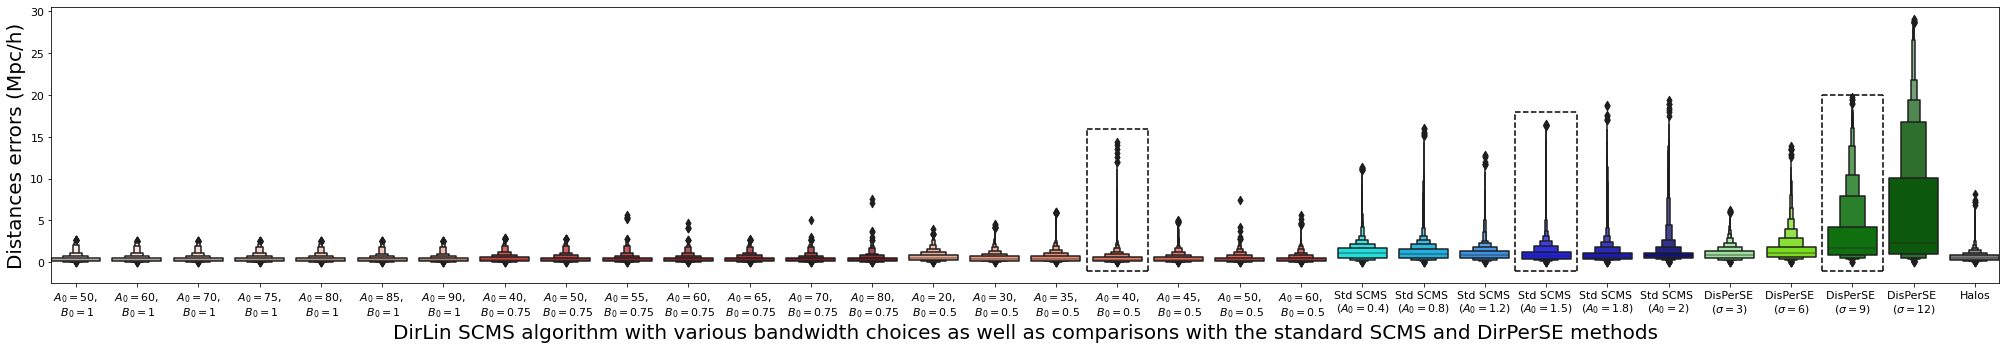

In [31]:
import seaborn as sns

plt.rcParams.update({'font.size': 11})  # Change the font sizes of ouput figures
plt.figure(figsize=(28, 5))
fila_diff = pd.DataFrame({'Distances errors (Mpc/h)': dist_err, 
                          'Methods': meth})

cmap = cm.get_cmap('Reds')
vals = np.concatenate([np.linspace(0.1, 0.32, 7), np.linspace(0.68, 0.9, 7), np.linspace(0.33, 0.67, 7)])
red_cols = []
for v in vals:
    red_cols.append(cmap(v))
    
colors = red_cols + ['cyan', 'deepskyblue', 'dodgerblue', 'blue', 'mediumblue', 'darkblue', 
                     'lightgreen', 'lawngreen', 'green', 'darkgreen', 'grey']

col_pal = dict(zip(labels, colors))
sns.boxenplot(y="Distances errors (Mpc/h)", x="Methods", data=fila_diff, palette=col_pal)
plt.ylabel('Distances errors (Mpc/h)', fontsize=20)
plt.xlabel('DirLin SCMS algorithm with various bandwidth choices as well as comparisons with the standard SCMS and DirPerSE methods', fontsize=20)

refy1 = [-1, 16]
refx1 = [16.5, 17.5]
plt.hlines(refy1, xmin=refx1[0], xmax=refx1[1], color='black', linestyles='--')
plt.vlines(refx1, ymin=refy1[0], ymax=refy1[1], color='black', linestyles='--')
plt.margins(x=0)

refy2 = [-1, 18]
refx2 = [23.5, 24.5]
plt.hlines(refy2, xmin=refx2[0], xmax=refx2[1], color='black', linestyles='--')
plt.vlines(refx2, ymin=refy2[0], ymax=refy2[1], color='black', linestyles='--')

refy3 = [-1, 20]
refx3 = [28.5, 29.5]
plt.hlines(refy3, xmin=refx3[0], xmax=refx3[1], color='black', linestyles='--')
plt.vlines(refx3, ymin=refy3[0], ymax=refy3[1], color='black', linestyles='--')
plt.tight_layout()
plt.savefig('./Figures/dist_err_comp_illustris.pdf', bbox_inches="tight")

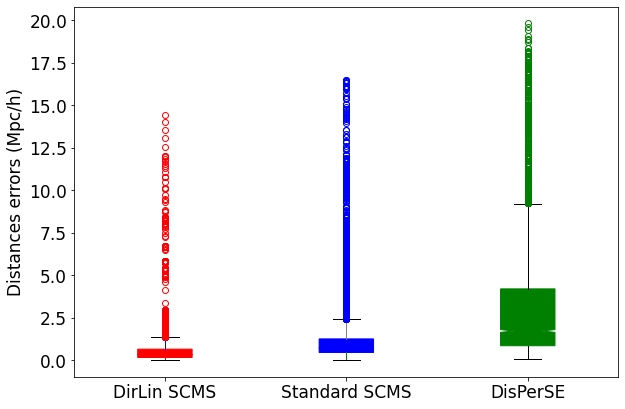

In [32]:
dist_err3 = []
labels = []
meth3 = np.empty(0, dtype='str')

with open("./Data_Outputs/Illustris_Data/dist_diff_DirLinSCMS_obs_cos_z0_0.5h_40b_comov.dat", "rb") as file:
    DirLin_obs_to_cos_comov, DirLin_cos_to_obs_comov = pickle.load(file)

dist_err3.append(DirLin_obs_to_cos_comov)
labels.append('DirLin SCMS')
meth3 = np.concatenate([meth3, np.repeat('DirLin SCMS', DirLin_obs_to_cos_comov.shape[0])])

with open("./Data_Outputs/Illustris_Data/dist_diff_EuSCMS_obs_cos_z0_1.5h_comov.dat", "rb") as file:
    Eu_obs_to_cos_comov, Eu_cos_to_obs_comov = pickle.load(file)
    
dist_err3.append(Eu_obs_to_cos_comov)
labels.append('Standard SCMS')
meth3 = np.concatenate([meth3, np.repeat('Standard SCMS', Eu_obs_to_cos_comov.shape[0])])

with open("./Data_Outputs/Illustris_Data/dist_diff_Disperse_obs_cos_z0_s9_comov.dat", "rb") as file:
    disp_obs_to_cos_comov, disp_cos_to_obs_comov = pickle.load(file)
    
dist_err3.append(disp_obs_to_cos_comov)
labels.append('DisPerSE')
meth3 = np.concatenate([meth3, np.repeat('DisPerSE', disp_obs_to_cos_comov.shape[0])])


plt.rcParams.update({'font.size': 17})  # Change the font sizes of ouput figures
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(9, 6))

bplot1 = ax1.boxplot(dist_err3,
                     vert=True,  # vertical box alignment
                     notch=True,  # notch shape
                     patch_artist=True,  # fill with color
                     medianprops = dict(linestyle=None, linewidth=0),
                     labels=labels)  # will be used to label x-ticks
ax1.set_ylabel('Distances errors (Mpc/h)')

colors = ['red', 'blue', 'green', 'grey']
for patch, color in zip(bplot1['boxes'], colors):
    patch.set_facecolor(color)
    patch.set_edgecolor(color)
    
for patch, color in zip(bplot1['fliers'], colors):
    patch.set(mec=color)
    
for patch, color in zip(bplot1['whiskers'], colors):
    patch.set_color(color)
fig.tight_layout()
# fig.savefig('./Figures/dist_err_comp_illustris_small.pdf', bbox_inches="tight")
plt.show()

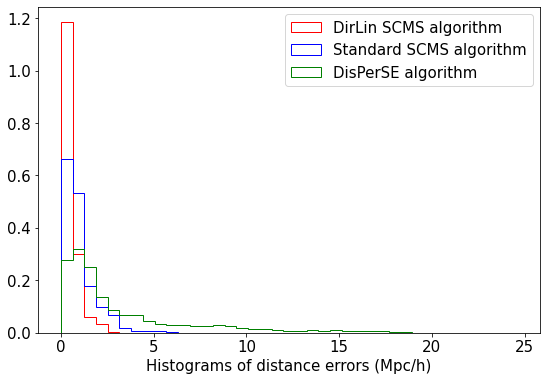

In [33]:
plt.rcParams.update({'font.size': 15})  # Change the font sizes of ouput figures
plt.figure(figsize=(9,6))
bins = np.linspace(0, max(disp_cos_to_obs_comov), 40)
plt.hist(DirLin_obs_to_cos_comov, bins=bins, fill=False, density=True, color='red', histtype='step', 
         label='DirLin SCMS algorithm')
plt.hist(Eu_obs_to_cos_comov, bins=bins, fill=False, density=True, color='blue', histtype='step', 
         label='Standard SCMS algorithm')
plt.hist(disp_obs_to_cos_comov, bins=bins, fill=False, density=True, color='green', histtype='step', 
         label='DisPerSE algorithm')
plt.legend()
plt.xlabel('Histograms of distance errors (Mpc/h)')
plt.show()

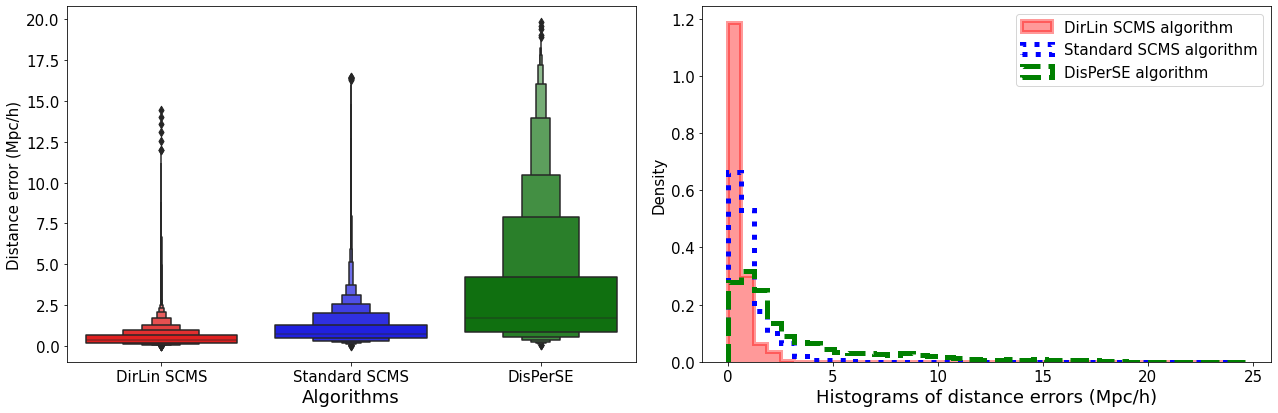

In [34]:
import seaborn as sns

plt.rcParams.update({'font.size': 15})  # Change the font sizes of ouput figures
plt.figure(figsize=(18, 6))
plt.subplot(121)

my_pal = {'Standard SCMS': 'blue', 'DisPerSE': 'green', 'DirLin SCMS': 'red'}
dist_err_df = {'Distance Error (Mpc/h)': np.concatenate(dist_err3), 'Algorithms': meth3}
sns.boxenplot(y="Distance Error (Mpc/h)", x="Algorithms", data=dist_err_df, palette=my_pal)
plt.xlabel('Algorithms', fontsize=18)
plt.ylabel('Distance error (Mpc/h)')


plt.subplot(122)
bins = np.linspace(0, max(disp_cos_to_obs_comov), 40)
plt.hist(DirLin_obs_to_cos_comov, bins=bins, fill=True, density=True, color='red', histtype='step', alpha=0.4,
         linewidth=4, label='DirLin SCMS algorithm')
plt.hist(Eu_obs_to_cos_comov, bins=bins, fill=False, density=True, color='blue', histtype='step', linewidth=5,
         linestyle='dotted', label='Standard SCMS algorithm')
plt.hist(disp_obs_to_cos_comov, bins=bins, fill=False, density=True, color='green', histtype='step', linewidth=5,
         linestyle='dashed', label='DisPerSE algorithm')
plt.legend()
plt.xlabel('Histograms of distance errors (Mpc/h)', fontsize=18)
plt.ylabel('Density')
plt.tight_layout()
plt.savefig('./Figures/dist_err_comp_illustris_small2.pdf', bbox_inches="tight")

In [35]:
import scipy.stats as stats

# Perform two sample t-test with unequal variances
print(stats.ttest_ind(a=DirLin_obs_to_cos_comov, b=Eu_obs_to_cos_comov, equal_var=False, alternative='less'))
stats.ks_2samp(DirLin_obs_to_cos_comov, Eu_obs_to_cos_comov)

Ttest_indResult(statistic=-155.10008001939073, pvalue=0.0)


KstestResult(statistic=0.37224571635053255, pvalue=0.0)

In [40]:
fac_lst = [(1, 50), (1, 60), (1, 70), (1, 75), (1, 80), (1, 85), (1, 90), 
           (0.75, 40), (0.75, 50), (0.75, 55), (0.75, 60), (0.75, 65), (0.75, 70), (0.75, 80), 
           (0.5, 20), (0.5, 30), (0.5, 35), (0.5, 40), (0.5, 45), (0.5, 50), (0.5, 60)]
thres = 3
gnd = []
gnd2 = np.empty(0)
labels = []
meth2 = np.empty(0, dtype='str')
vol = (4*np.pi/3)*(thres)**3
gnd_mean = []
gnd_std = []

for fac_h, fac_b in fac_lst:
    with open("./Data_Outputs/Illustris_Data/GND_DirLinSCMS_z0_"+str(fac_h)+"h_"+str(fac_b)+"b_r"+str(thres)+".dat", "rb") as file:
        gnd_DirLin = pickle.load(file)
    
    gnd.append(gnd_DirLin/(vol))
    gnd2 = np.concatenate([gnd2, gnd_DirLin/(vol)])
    gnd_mean.append(np.mean(gnd_DirLin/(vol)))
    gnd_std.append(np.std(gnd_DirLin/(vol)))
    meth2 = np.concatenate([meth2, np.repeat('$A_0=$'+str(fac_b)+',\n $B_0=$'+str(fac_h), 
                                           gnd_DirLin.shape[0])])
    labels.append('$A_0=$'+str(fac_b)+',\n $B_0=$'+str(fac_h))

In [41]:
for fac in [0.4, 0.8, 1.2, 1.5, 1.8, 2]:
    with open("./Data_Outputs/Illustris_Data/GND_EuSCMS_z0_"+str(fac)+"h.dat", "rb") as file:
        gnd_Eu = pickle.load(file)
    gnd.append(gnd_Eu/(vol))
    gnd2 = np.concatenate([gnd2, gnd_Eu/(vol)])
    gnd_mean.append(np.mean(gnd_Eu/(vol)))
    gnd_std.append(np.std(gnd_Eu/(vol)))
    labels.append('Std SCMS \n($A_0='+str(fac)+'$)')
    meth2 = np.concatenate([meth2, np.repeat('Std SCMS \n($A_0='+str(fac)+'$)', gnd_Eu.shape[0])])

In [43]:
for sig in [3, 6, 9, 12]:
    with open("./Data_Outputs/Illustris_Data/GND_Disperse_z0_s"+str(sig)+"_comov.dat", "rb") as file:
        gnd_disp = pickle.load(file)
    gnd.append(gnd_disp/(vol))
    gnd2 = np.concatenate([gnd2, gnd_disp/(vol)])
    gnd_mean.append(np.mean(gnd_disp/(vol)))
    gnd_std.append(np.std(gnd_disp/(vol)))
    labels.append('DisPerSE \n($\sigma='+str(sig)+'$)')
    meth2 = np.concatenate([meth2, np.repeat('DisPerSE \n($\sigma='+str(sig)+'$)', gnd_disp.shape[0])])

In [46]:
with open("./Data_Outputs/Illustris_Data/GND_halo_z0_obs.dat", "rb") as file:
    gnd_halo = pickle.load(file)
gnd.append(gnd_halo/(vol))
gnd2 = np.concatenate([gnd2, gnd_halo/(vol)])
gnd_mean.append(np.mean(gnd_halo/(vol)))
gnd_std.append(np.std(gnd_halo/(vol)))
labels.append('Halos')
meth2 = np.concatenate([meth2, np.repeat('Halos', gnd_halo.shape[0])])

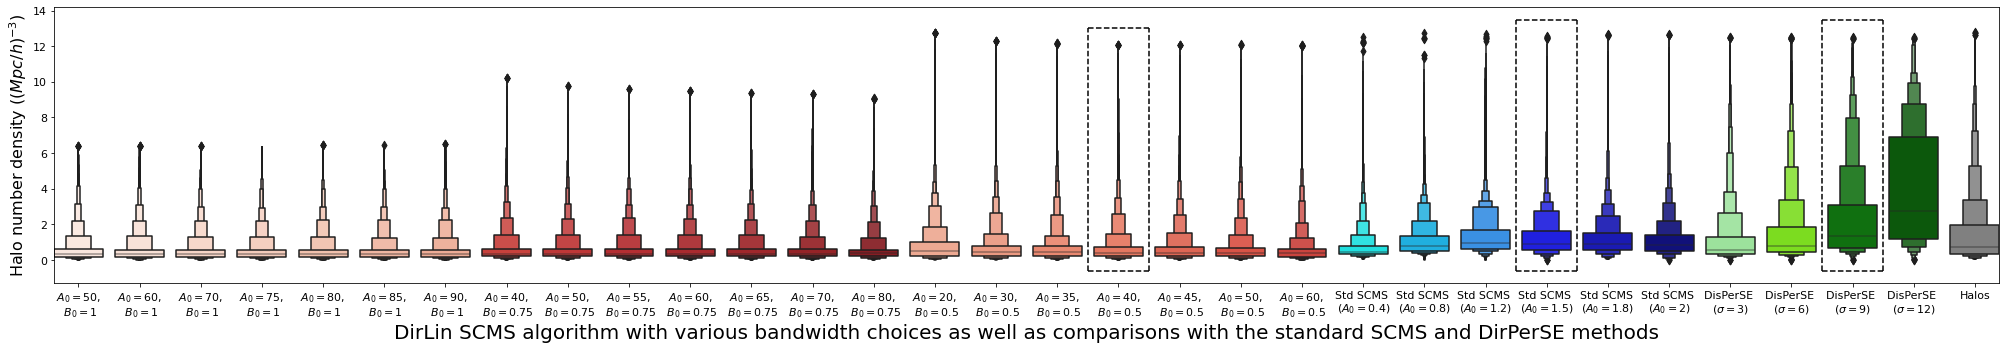

In [47]:
plt.rcParams.update({'font.size': 11})  # Change the font sizes of ouput figures
plt.figure(figsize=(28, 5))
fila_diff = pd.DataFrame({'Halo number density': gnd2, 
                          'Methods': meth2})

cmap = cm.get_cmap('Reds')
vals = np.concatenate([np.linspace(0.1, 0.32, 7), np.linspace(0.68, 0.9, 7), np.linspace(0.33, 0.67, 7)])
red_cols = []
for v in vals:
    red_cols.append(cmap(v))
    
colors = red_cols + ['cyan', 'deepskyblue', 'dodgerblue', 'blue', 'mediumblue', 'darkblue', 
                     'lightgreen', 'lawngreen', 'green', 'darkgreen', 'grey']

col_pal = dict(zip(labels, colors))
sns.boxenplot(y="Halo number density", x="Methods", data=fila_diff, palette=col_pal)
plt.ylabel('Halo number density ($(Mpc/h)^{-3}$)', fontsize=16)
plt.xlabel('DirLin SCMS algorithm with various bandwidth choices as well as comparisons with the standard SCMS and DirPerSE methods', fontsize=20)

refy1 = [-0.6, 13]
refx1 = [16.5, 17.5]
plt.hlines(refy1, xmin=refx1[0], xmax=refx1[1], color='black', linestyles='--')
plt.vlines(refx1, ymin=refy1[0], ymax=refy1[1], color='black', linestyles='--')
plt.margins(x=0)

refy2 = [-0.6, 13.5]
refx2 = [23.5, 24.5]
plt.hlines(refy2, xmin=refx2[0], xmax=refx2[1], color='black', linestyles='--')
plt.vlines(refx2, ymin=refy2[0], ymax=refy2[1], color='black', linestyles='--')

refy3 = [-0.6, 13.5]
refx3 = [28.5, 29.5]
plt.hlines(refy3, xmin=refx3[0], xmax=refx3[1], color='black', linestyles='--')
plt.vlines(refx3, ymin=refy3[0], ymax=refy3[1], color='black', linestyles='--')
plt.tight_layout()
plt.savefig('./Figures/GND_comp_illustris.pdf', bbox_inches="tight")